# **Robust Detection of AI-Generated Images Using Hybrid CNN-Frequency Fusion and Adversarial Training.**

|-- NOTE: to run the code please access datasets on your Google drive:  https://drive.google.com/drive/folders/1KLGoja9GYVT6qh3aX4SWAZawGDkHwfkU?usp=sharing

|-- If dataset not accessed reach the code on GitGub at: https://github.com/esraalmaeeni/ai-image-detection-hybrid-CNN-freq

the project proposes a hybrid architecture that integrates following branches:
* The **spatial branch** employs a convolutional neural network (CNN) to extract discriminative features from the raw image.
* The **frequency branch** processes the Fourier-transformed image to capture global periodic artifacts characteristic of AI-generated content.
* An **attention-based fusion module** then combines these heterogeneous features to form a robust representation.
* an **adversarial discriminator**—incorporated via a gradient reversal layer—enforces domain invariance by mitigating reliance on generator-specific artifacts.

>* Datasets: https://www.kaggle.com/datasets/alessandrasala79/ai-vs-human-generated-dataset | Labels: {Real(0), Fake(1)}
>* Loss: Binary Cross Entropy Loss `nn.BCEWithLogits()`
>* Optimizer: `torch.optim.SGD`
>* Evaluation Metrices: Accuracy, confusion matrix: `torchmetrics.ConfusionMatrix`
----------------------------------------




## 1. Import domain libraries and setup agnostic device

In [ ]:
# Import required libraries
import torch
from torch import nn

#import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

print(torch.__version__)
print(torchvision.__version__)

2.6.0+cu124
0.21.0+cu124


In [ ]:
# Setup agnostic device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 2. Get Dataset

Datasets: https://www.kaggle.com/datasets/alessandrasala79/ai-vs-human-generated-dataset | Labels: {Real(0), Fake(1)}

In [ ]:
import os
from google.colab import drive

# Check if the drive is already mounted
if not os.path.ismount('/content/drive'):
    drive.mount('/content/drive')
else:
    print("Drive already mounted.")

Drive already mounted.


In [ ]:
!ls "/content/drive/MyDrive/AI_Project_Data/ai_vs_human_dataset"

test.csv  test_data_v2	train.csv  train_data


### 2.1 Data Preparation

In [ ]:
import os
import pandas as pd

# Setup the data dir
data_dir = "/content/drive/MyDrive/AI_Project_Data/ai_vs_human_dataset"

# Prepare train data and assign them to labels using pandas and link each csv to its image in train folder
train_folder = "/content/drive/MyDrive/AI_Project_Data/ai_vs_human_dataset/train_data"

train_csv_path = os.path.join(data_dir, "train.csv")
train_df = pd.read_csv(train_csv_path)

# Map numeric labels to string labels
label_map = {0: "Human-Created Image", 1: "AI-Generated Image"}
train_df["label"] = train_df["label"].map(label_map)
train_df["label"].unique()

array(['AI-Generated Image', 'Human-Created Image'], dtype=object)

In [ ]:
# remove the repeatition of train_data in image path in csv file
def fix_image_path_train(file_name):
    file_name = file_name.strip()
    if file_name.startswith("train_data/"):
        file_name = file_name.replace("train_data/", "", 1)
    return os.path.join(train_folder, file_name)

train_df["image_path"] = train_df["file_name"].apply(fix_image_path_train)
train_df.head()

Unnamed: 0                                        file_name  \
0           0  train_data/a6dcb93f596a43249135678dfcfc17ea.jpg   
1           1  train_data/041be3153810433ab146bc97d5af505c.jpg   
2           2  train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg   
3           3  train_data/8542fe161d9147be8e835e50c0de39cd.jpg   
4           4  train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg   

                 label                                         image_path  
0   AI-Generated Image  /content/drive/MyDrive/AI_Project_Data/ai_vs_h...  
1  Human-Created Image  /content/drive/MyDrive/AI_Project_Data/ai_vs_h...  
2   AI-Generated Image  /content/drive/MyDrive/AI_Project_Data/ai_vs_h...  
3  Human-Created Image  /content/drive/MyDrive/AI_Project_Data/ai_vs_h...  
4   AI-Generated Image  /content/drive/MyDrive/AI_Project_Data/ai_vs_h...

In [ ]:
print(train_df.columns)

Index(['Unnamed: 0', 'file_name', 'label', 'image_path'], dtype='object')


In [ ]:
# Prepare evaluation data/ divide train data to train and eval
from sklearn.model_selection import train_test_split

# Split Dataset
train_df_split, eval_df_split = train_test_split(
    train_df,
    test_size=0.2,  # eval is 20% of train data
    stratify=train_df["label"],  # for balance
    random_state=42  # to get fixed dataset
)

# length of train and eval dataset
print("Train size:", len(train_df_split))
print("Eval size:", len(eval_df_split))

# print out eval dataframe
eval_df_split.head()

Train size: 63960
Eval size: 15990


Unnamed: 0                                        file_name  \
37735       37735  train_data/84f39638fffa405db349a67dcc71e66b.jpg   
10306       10306  train_data/2c2dd2cce2564a7595ff22f004e4a406.jpg   
34977       34977  train_data/481db80397cf4ec58f5d6e9b478d9494.jpg   
7751         7751  train_data/e4992e7012b942c788249bf7ea401c28.jpg   
55086       55086  train_data/41e8bbf4a8b54c1ca3d964ffb1995171.jpg   

                     label                                         image_path  
37735  Human-Created Image  /content/drive/MyDrive/AI_Project_Data/ai_vs_h...  
10306   AI-Generated Image  /content/drive/MyDrive/AI_Project_Data/ai_vs_h...  
34977  Human-Created Image  /content/drive/MyDrive/AI_Project_Data/ai_vs_h...  
7751   Human-Created Image  /content/drive/MyDrive/AI_Project_Data/ai_vs_h...  
55086   AI-Generated Image  /content/drive/MyDrive/AI_Project_Data/ai_vs_h...

In [ ]:
train_df_split.head()

Unnamed: 0                                        file_name  \
23022       23022  train_data/882781c4315e4ccea1a15ec07046b3ad.jpg   
65032       65032  train_data/497f402e8f56406cb86ed1270484b497.jpg   
41548       41548  train_data/8813cab4180040eca91e4257fdd677c5.jpg   
61565       61565  train_data/e3e36d8f4ab3466b97f29e38bdead05b.jpg   
72780       72780  train_data/197cca33df9547abbd51f0d514af0ec1.jpg   

                     label                                         image_path  
23022   AI-Generated Image  /content/drive/MyDrive/AI_Project_Data/ai_vs_h...  
65032   AI-Generated Image  /content/drive/MyDrive/AI_Project_Data/ai_vs_h...  
41548   AI-Generated Image  /content/drive/MyDrive/AI_Project_Data/ai_vs_h...  
61565  Human-Created Image  /content/drive/MyDrive/AI_Project_Data/ai_vs_h...  
72780   AI-Generated Image  /content/drive/MyDrive/AI_Project_Data/ai_vs_h...

In [ ]:
# prepare small subset of train and eval datasets for experimentation
# Split Dataset
train_df_mini_0, eval_df_mini_0 = train_test_split(
    eval_df_split,
    test_size=0.2,  # eval is 20% of train data
    stratify=eval_df_split["label"],  # for balance
    random_state=42  # to get fixed dataset
)

train_df_mini, eval_df_mini = train_test_split(
    eval_df_mini_0,
    test_size=0.2,  # eval is 20% of train data
    stratify=eval_df_mini_0["label"],  # for balance
    random_state=42  # to get fixed dataset
)

# length of train and eval dataset
print("Train size:", len(train_df_mini))
print("Eval size:", len(eval_df_mini))

Train size: 2558
Eval size: 640


In [ ]:
# Prepare test data using pandas and link each csv to its image in test folder
test_folder = "/content/drive/MyDrive/AI_Project_Data/ai_vs_human_dataset/test_data_v2"
test_csv_path = os.path.join(data_dir, "test.csv")
test_df = pd.read_csv(test_csv_path)

def fix_image_path_test(file_name):
    file_name = file_name.strip()
    if file_name.startswith("test_data_v2/"):
        file_name = file_name.replace("test_data_v2/", "", 1)
    return os.path.join(train_folder, file_name)

test_df["image_path"] = test_df["id"].apply(fix_image_path_test)


test_df.head()

id  \
0  test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg   
1  test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg   
2  test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg   
3  test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg   
4  test_data_v2/a16495c578b7494683805484ca27cf9f.jpg   

                                          image_path  
0  /content/drive/MyDrive/AI_Project_Data/ai_vs_h...  
1  /content/drive/MyDrive/AI_Project_Data/ai_vs_h...  
2  /content/drive/MyDrive/AI_Project_Data/ai_vs_h...  
3  /content/drive/MyDrive/AI_Project_Data/ai_vs_h...  
4  /content/drive/MyDrive/AI_Project_Data/ai_vs_h...

In [ ]:
class_names = ["Human-Created Image", "AI-Generated Image"]
class_dict = {"Human-Created Image": 0 , "AI-Generated Image": 1}
class_names, class_dict

(['Human-Created Image', 'AI-Generated Image'],
 {'Human-Created Image': 0, 'AI-Generated Image': 1})

### 2.2 Data Exploration

In [ ]:
# Setup train and test path and label
train_images = os.listdir(train_folder)
test_images = os.listdir(test_folder)
print(f"Number of actual images in train_data folder: {len(train_images)}")
print(f"Number of actual images in train_data folder: {len(test_images)}")

Number of actual images in train_data folder: 79950
Number of actual images in train_data folder: 5540


In [ ]:
import os
import pandas as pd

def summarize_dataset(dir_path, preview_rows=3):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        csvs = [f for f in filenames if f.endswith('.csv')]
        excels = [f for f in filenames if f.endswith('.xlsx')]
        images = [f for f in filenames if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        others = [f for f in filenames if f not in csvs + excels + images]

        print(f"\nPath: {dirpath}")
        print(f"  This path contains:\n {len(dirnames)} subdirs | {len(csvs)} CSVs | {len(excels)} Excels | {len(images)} images | {len(others)} other files")

        for file in csvs + excels:
            path = os.path.join(dirpath, file)
            try:
                df = pd.read_csv(path, nrows=preview_rows) if file.endswith('.csv') else pd.read_excel(path, nrows=preview_rows)
                print(f"{file}: ~{df.shape[1]} features (showing {preview_rows} rows)")
            except Exception as e:
                print(f"Could not read {file}: {e}")


summarize_dataset(data_dir)


Path: /content/drive/MyDrive/AI_Project_Data/ai_vs_human_dataset
  This path contains:
 2 subdirs | 2 CSVs | 0 Excels | 0 images | 0 other files
test.csv: ~1 features (showing 3 rows)
train.csv: ~3 features (showing 3 rows)

Path: /content/drive/MyDrive/AI_Project_Data/ai_vs_human_dataset/test_data_v2
  This path contains:
 0 subdirs | 0 CSVs | 0 Excels | 5540 images | 0 other files

Path: /content/drive/MyDrive/AI_Project_Data/ai_vs_human_dataset/train_data
  This path contains:
 0 subdirs | 0 CSVs | 0 Excels | 79950 images | 0 other files


### 2.3 Data cleaning and removing missing data

In [ ]:
import os
import pandas as pd

def check_dataset_consistency(csv_path, folder_path, file_column="file_name"):
    """
    Check for missing or extra image files between CSV and actual folder.

    Parameters:
    - csv_path: path to the CSV file (e.g., 'train.csv')
    - folder_path: path to the image folder
    - file_column: name of the column in CSV that contains file names

    Prints:
    - Number of missing files from folder
    - Number of extra files not listed in CSV
    - Optionally: names of a few mismatched files for debugging
    """
    # Load CSV
    df = pd.read_csv(csv_path)

    # Clean CSV file names (remove paths/spaces)
    csv_filenames = set(
        df[file_column].dropna().apply(lambda x: os.path.basename(str(x)).strip())
    )

    # Get actual filenames from folder
    folder_filenames = set(os.listdir(folder_path))

    # Compare sets
    missing_in_folder = csv_filenames - folder_filenames
    not_listed_in_csv = folder_filenames - csv_filenames

    # Print results
    print(f"Total filenames in CSV: {len(csv_filenames)}")
    print(f"Total images in folder: {len(folder_filenames)}\n")

    print(f"-------------\nImages listed in CSV but missing from folder: {len(missing_in_folder)}")
    if missing_in_folder:
        print(" Example:", list(missing_in_folder)[:5])

    print(f"Images found in folder but not listed in CSV: {len(not_listed_in_csv)}")
    if not_listed_in_csv:
        print(" Example:", list(not_listed_in_csv)[:5])

    return missing_in_folder, not_listed_in_csv

In [ ]:
check_dataset_consistency(train_csv_path, train_folder)

Total filenames in CSV: 79950
Total images in folder: 79950

-------------
Images listed in CSV but missing from folder: 0
Images found in folder but not listed in CSV: 0


(set(), set())

> The dataset is clean and do not have any missing data.

### 2.4 Visualizition of random images

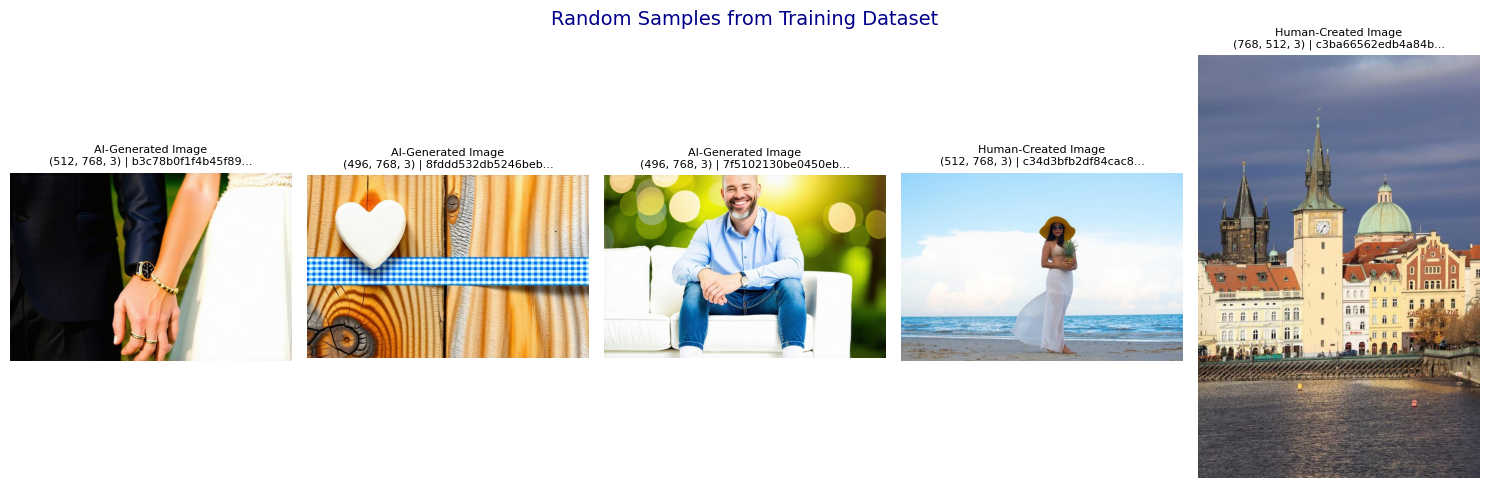

In [ ]:
# show random images from the dataset
import numpy as np
from PIL import Image

# Get a random sample
samples = train_df.sample(5).reset_index(drop=True)
plt.figure(figsize=(15, 5))

# Show random images
plt.suptitle("Random Samples from Training Dataset", fontsize=14, color='darkblue')

for i in range(5):
    sample = samples.iloc[i]
    img = Image.open(sample["image_path"]).convert("RGB")
    img_array = np.asarray(img) # to show shape using numpy

    label = sample["label"] # to get the label

    plt.subplot(1, 5, i + 1)
    plt.imshow(img)

    file_name = os.path.basename(sample["image_path"]) # to get img path
    if len(file_name) > 20:
      file_name = file_name[:17] + "..."

    title = f"{label}\n{img_array.shape} | {file_name}"
    plt.title(title, fontsize=8, color='black')

    plt.axis("off")

plt.tight_layout()
plt.show()

array([[[137,  82,  88],
        [136,  81,  87],
        [135,  80,  86],
        ...,
        [ 40,  37,  58],
        [ 39,  36,  57],
        [ 38,  35,  56]],

       [[137,  82,  88],
        [136,  81,  87],
        [135,  80,  86],
        ...,
        [ 39,  36,  57],
        [ 38,  35,  56],
        [ 37,  34,  55]],

       [[136,  81,  86],
        [136,  81,  86],
        [136,  81,  86],
        ...,
        [ 37,  34,  55],
        [ 36,  33,  54],
        [ 36,  33,  54]],

       ...,

       [[ 25,  26,  54],
        [ 25,  26,  54],
        [ 25,  26,  54],
        ...,
        [ 18,  20,  59],
        [ 18,  20,  59],
        [ 18,  20,  59]],

       [[ 25,  26,  54],
        [ 25,  26,  54],
        [ 25,  26,  54],
        ...,
        [ 18,  20,  61],
        [ 18,  20,  61],
        [ 18,  20,  61]],

       [[ 25,  26,  54],
        [ 25,  26,  54],
        [ 25,  26,  54],
        ...,
        [ 18,  20,  61],
        [ 18,  20,  61],
        [ 18,  20,  61]]], dtype=uint8)
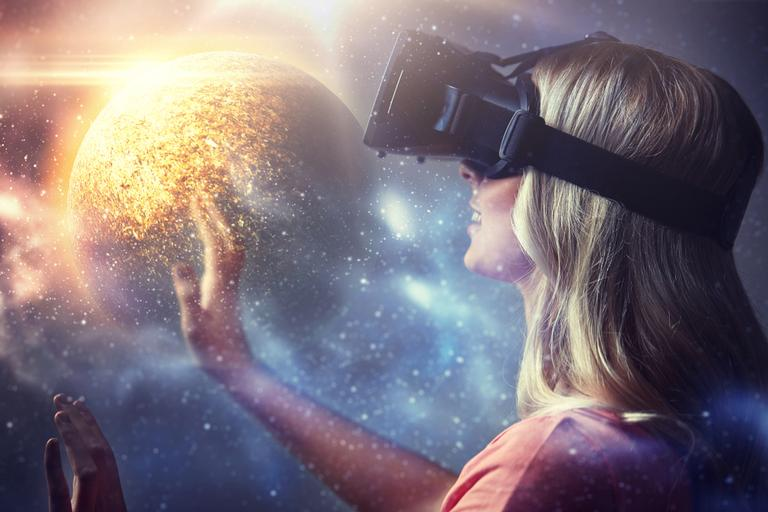

In [ ]:
# Img as an array
img_array

## 3. Transform the data into tensors (numerical representation of images)
`torchvision.transforms` ->
`torch.utils.data.dataset` ->
`torch.utils.data.DataLoader`

In [ ]:
import torch
import os
import pathlib
import random
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from PIL import Image
from typing import Tuple, Dict, List, Optional

In [ ]:
# Data is not normalized/transformed yet
print(img_array.min(), img_array.max())

2 255


### 3.1 Transforming data with `torchvision.transforms`

In [ ]:
train_transform_spatial = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

eval_transform_spatial = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

frequency_transform = transforms.Compose([
    transforms.Normalize(mean=[0.5], std=[0.5])
])

Before transformation
-------------------
img shape: (768, 512, 3)
img type: uint8


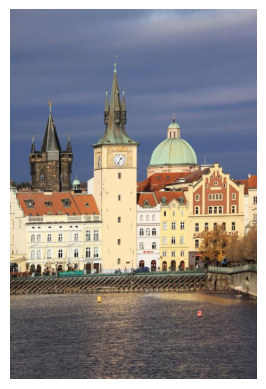

After transformation
-------------------
torch.Size([3, 224, 224])
torch.float32


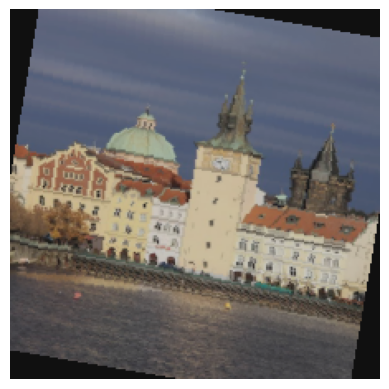

In [ ]:
# Understanding our data

def unnormalize(tensor):
    mean = torch.tensor([0.5, 0.5, 0.5])
    std = torch.tensor([0.5, 0.5, 0.5])
    return tensor * std[:, None, None] + mean[:, None, None]

def show_tensor_image(tensor, ax=None):
    unnorm = unnormalize(tensor).permute(1, 2, 0).numpy()
    if ax is None:
        plt.imshow(unnorm)
        plt.axis('off')
    else:
        ax.imshow(unnorm)
        ax.axis('off')

# Before transformation
print("Before transformation\n-------------------")
print(f"img shape: {img_array.shape}")
print(f"img type: {img_array.dtype}")
#print(img_array)
plt.imshow(img_array)
plt.axis("off")
plt.show()

# After transformation
print("After transformation\n-------------------")
print(train_transform_spatial(img).shape)
print(train_transform_spatial(img).dtype)
show_tensor_image(train_transform_spatial(img))

In [ ]:
def plot_transformed_images(df, image_path: str, transform, n=5, seed=42):
    """
    Randomly selects n images from a DataFrame and plots the original
    vs. the transformed version, along with label, shape, and file name.
    """
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    # Sample from the dataframe
    samples = df.sample(n).reset_index(drop=True)

    for i in range(n):
        sample = samples.iloc[i]
        img_path = sample[image_path]
        label = sample["label"]

        with Image.open(img_path).convert("RGB") as img:
            img_array = np.asarray(img)
            transformed_img = transform(img)

            fig, ax = plt.subplots(1, 2, figsize=(8, 4))

            # Original image
            ax[0].imshow(img)
            ax[0].set_title(f"Original\n{img_array.shape}")
            ax[0].axis("off")

            # Transformed image (unnormalized)
            show_tensor_image(transformed_img, ax[1])
            ax[1].set_title(f"Transformed\n{tuple(transformed_img.shape[-2:])}")
            ax[1].axis("off")

            # Format file name
            file_name = os.path.basename(img_path)
            if len(file_name) > 20:
                file_name = file_name[:17] + "..."

            # Overall title
            fig.suptitle(f"{label} | {file_name}", fontsize=12, color='darkblue')
            plt.tight_layout()
            plt.show()

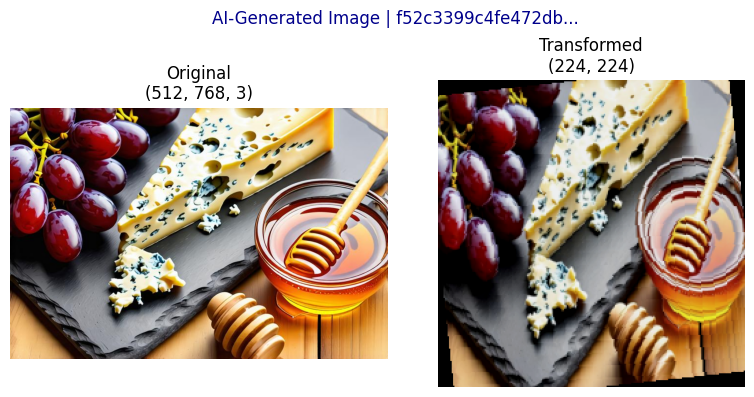

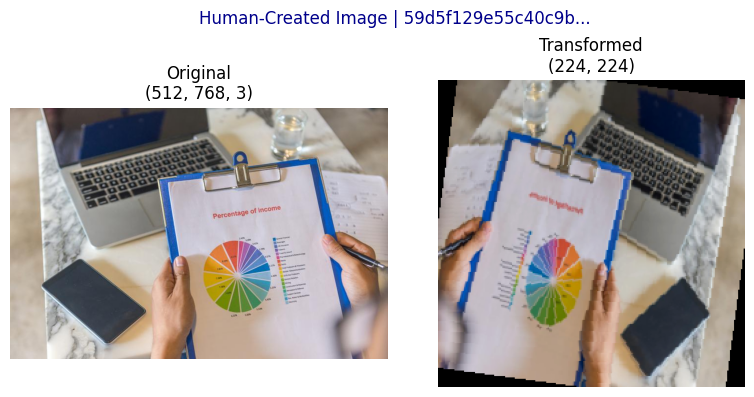

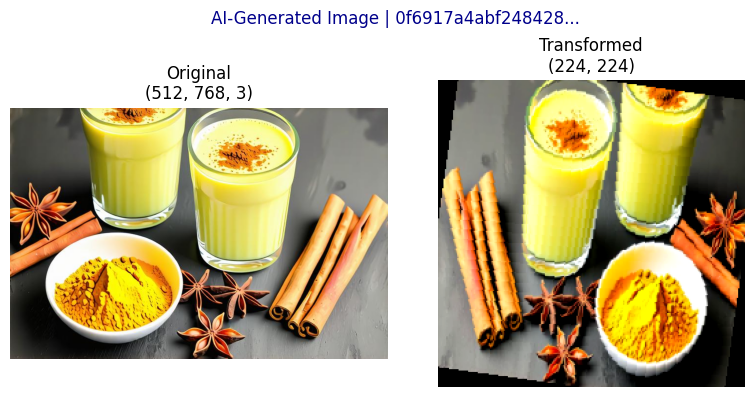

In [ ]:
plot_transformed_images(
    df=train_df,
    image_path= "image_path",
    transform=train_transform_spatial,
    n=3,
    seed=None,
)

### 3.2 Create a custom dataset using `torch.utils.data.Dataset`

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd
from typing import Optional, Tuple
import numpy as np
# Remove Resize import here if it's only used inside _to_frequency_domain
# from torchvision.transforms import Resize

class ImageFolderCustom(Dataset):
    def __init__(self,
                 dataframe: pd.DataFrame,
                 has_labels: bool = True,
                 spatial_transform: Optional[transforms.Compose] = None,
                 frequency_transform: Optional[transforms.Compose] = None,
                 class_to_idx: Optional[dict] = None):
        """
        Custom dataset for loading both spatial and frequency representations of images.
        """
        self.df = dataframe.reset_index(drop=True)
        self.has_labels = has_labels
        self.image_paths = self.df["image_path"].tolist()
        self.spatial_transform = spatial_transform
        self.frequency_transform = frequency_transform # Will be applied inside _to_frequency_domain

        if self.has_labels:
            self.labels = self.df["label"].tolist()
            # Ensure consistent class mapping
            self.class_to_idx = class_to_idx or {
                "Human-Created Image": 0,
                "AI-Generated Image": 1
            }
            # Make sure df labels are in the map keys
            if not all(label in self.class_to_idx for label in self.df["label"].unique()):
                 print("Warning: Some labels in dataframe are not in class_to_idx!")
            self.classes = list(self.class_to_idx.keys())
        else:
            self.labels = None
            self.class_to_idx = None
            self.classes = None

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor, int]:
        """
        Get spatial image tensor, frequency image tensor, and label index.
        """
        img_path = self.image_paths[index] # Use the input 'index'

        # --- Load Image ONCE ---
        try:
            # Load and ensure image is RGB for spatial processing consistency
            original_image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Decide how to handle errors: skip, return None, raise?
            # Example: Return None values to be potentially filtered by collate_fn
            # return None, None, -1 # Or raise an error
            raise IOError(f"Failed to load image: {img_path}") from e

        # --- Prepare Spatial Input ---
        # Apply spatial transforms (should include ToTensor & 3-channel Normalize)
        if self.spatial_transform:
            # Apply transform to a copy if transform modifies in place
            # or if original_image is needed unmodified elsewhere
            spatial_image_tensor = self.spatial_transform(original_image.copy())
        else:
            # Default behavior if no transform provided (e.g., just convert to tensor)
            # Note: Normalization is usually crucial
            spatial_image_tensor = transforms.ToTensor()(original_image)


        # --- Prepare Frequency Input ---
        # Use the original image before spatial augmentation/normalization
        # The _to_frequency_domain method now handles its own conversion/transforms
        frequency_image_tensor = self._to_frequency_domain(original_image.copy())


        # --- Get Label Index ---
        if self.has_labels:
            label_str = self.labels[index] # Use the input 'index'
            # Use the class_to_idx mapping defined in __init__
            if label_str in self.class_to_idx:
                 label_idx = self.class_to_idx[label_str]
            else:
                 # Handle unexpected labels
                 print(f"Warning: Unknown label '{label_str}' for image {img_path}. Assigning default label -1.")
                 label_idx = -1 # Or raise ValueError
                 # raise ValueError(f"Unknown label: {label_str}")
        else:
            label_idx = -1 # Or some placeholder for datasets without labels


        # --- Return Correctly Processed Tensors ---
        return spatial_image_tensor, frequency_image_tensor, label_idx


    def _to_frequency_domain(self, img_pil: Image.Image) -> torch.Tensor:
        """
        Convert the given PIL image (assumed RGB) to the frequency domain.
        Handles resizing, tensor conversion, FFT, averaging, log compression,
        and applies self.frequency_transform if provided.
        """
        # Standardize size (important for consistent FFT results)
        resize = transforms.Resize((224, 224)) # Match expected input size for models
        img_resized = resize(img_pil)

        # Convert PIL Image to numpy array -> torch Tensor -> permute -> normalize [0,1]
        img_np = np.array(img_resized)       # Shape: (H, W, C) e.g., (224, 224, 3)
        img_tensor = torch.from_numpy(img_np).float() # Shape: (H, W, C)
        img_tensor = img_tensor.permute(2, 0, 1) # Shape: (C, H, W) e.g., (3, 224, 224)
        img_tensor = img_tensor / 255.0          # Normalize pixel values to [0, 1]

        # Apply FFT (on H, W dimensions), shift zero frequency to center, get magnitude
        img_fft = torch.fft.fft2(img_tensor, dim=(-2, -1))
        img_fft_shifted = torch.fft.fftshift(img_fft, dim=(-2, -1))
        img_mag = torch.abs(img_fft_shifted) # Magnitude has shape (C, H, W)

        # Average magnitude across channels to get a single frequency map
        img_mag_avg = img_mag.mean(dim=0, keepdim=True) # Shape: (1, H, W)

        # Apply log compression for better visualization and potentially learning
        img_freq = torch.log1p(img_mag_avg) # log(1 + x), shape: (1, H, W)

        # Apply specific frequency domain transformations if provided
        # (e.g., normalization using mean=[0.5], std=[0.5] for the single channel)
        if self.frequency_transform:
            img_freq = self.frequency_transform(img_freq) # Expects [1, H, W] tensor

        return img_freq.float() # Ensure float tensor output

In [ ]:
len(eval_df_split)

15990

In [ ]:
train_dataset = ImageFolderCustom(
    dataframe=train_df_split,
    has_labels=True,
    spatial_transform=train_transform_spatial,
    frequency_transform=frequency_transform,
    class_to_idx=class_dict
)

eval_dataset = ImageFolderCustom(
    dataframe=eval_df_split,
    has_labels=True,
    spatial_transform=eval_transform_spatial,
    frequency_transform=frequency_transform,
    class_to_idx=class_dict
)

test_dataset = ImageFolderCustom(
    dataframe=test_df,
    has_labels=False,
    spatial_transform=eval_transform_spatial,
    frequency_transform=frequency_transform,
    class_to_idx=class_dict
)

In [ ]:
len(eval_dataset)

15990

In [ ]:
#mini subsets
train_dataset_mini = ImageFolderCustom(
    dataframe=train_df_mini,
    has_labels=True,
    spatial_transform=train_transform_spatial,
    frequency_transform=frequency_transform,
    class_to_idx=class_dict
)

eval_dataset_mini = ImageFolderCustom(
    dataframe=eval_df_mini,
    has_labels=True,
    spatial_transform=eval_transform_spatial,
    frequency_transform=frequency_transform,
    class_to_idx=class_dict
)

In [ ]:
len(eval_dataset_mini)

640

In [ ]:
# Display summary of train and test datasets
def display_dataset_info(dataset, name: str, show_paths: bool = True, num_paths: int = 10):
    print(f"\n{name} Summary")
    print("-" * (len(name) + 8))
    print(f"Total samples       : {len(dataset)}")
    if hasattr(dataset, "class_to_idx") and dataset.class_to_idx:
        print(f"Class-to-Index Map  : {dataset.class_to_idx}")
    if show_paths and hasattr(dataset, "image_paths"):
        sample_paths = dataset.image_paths[:num_paths]
        print(f"Sample image paths  :")
        for i, path in enumerate(sample_paths):
            print(f"  [{i+1}] {path}")

# Displaying both datasets
display_dataset_info(train_dataset, "Train Dataset")
display_dataset_info(eval_dataset, "Eval Dataset")
display_dataset_info(test_dataset, "Test Dataset")


Train Dataset Summary
---------------------
Total samples       : 63960
Class-to-Index Map  : {'Human-Created Image': 0, 'AI-Generated Image': 1}
Sample image paths  :
  [1] /content/drive/MyDrive/AI_Project_Data/ai_vs_human_dataset/train_data/882781c4315e4ccea1a15ec07046b3ad.jpg
  [2] /content/drive/MyDrive/AI_Project_Data/ai_vs_human_dataset/train_data/497f402e8f56406cb86ed1270484b497.jpg
  [3] /content/drive/MyDrive/AI_Project_Data/ai_vs_human_dataset/train_data/8813cab4180040eca91e4257fdd677c5.jpg
  [4] /content/drive/MyDrive/AI_Project_Data/ai_vs_human_dataset/train_data/e3e36d8f4ab3466b97f29e38bdead05b.jpg
  [5] /content/drive/MyDrive/AI_Project_Data/ai_vs_human_dataset/train_data/197cca33df9547abbd51f0d514af0ec1.jpg
  [6] /content/drive/MyDrive/AI_Project_Data/ai_vs_human_dataset/train_data/0518f3550a914d148ba6db6c813c60ba.jpg
  [7] /content/drive/MyDrive/AI_Project_Data/ai_vs_human_dataset/train_data/b00865f0a11f49d586f69ce57fc43113.jpg
  [8] /content/drive/MyDrive/AI_Project_

In [ ]:
class_names = train_dataset.class_to_idx
class_names

{'Human-Created Image': 0, 'AI-Generated Image': 1}

### 3.3 Display random images

In [ ]:
#we will take random sample images and visualize them
random_sample_indexes = random.sample(range(len(train_dataset)), k=10)
random_sample_indexes

[41192, 17520, 17554, 61191, 49189, 16760, 10547, 32207, 53181, 21041]

In [ ]:
def display_random_images(dataset: torch.utils.data.Dataset,
                          class_to_idx: dict = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    """
    Displays random sample images from a dataset with optional class names and shape info.
    """
    if n > 10:
        n = 10
        display_shape = False
        print("Capping number of images to 10 and hiding shape info for clarity.")

    if seed is not None:
        random.seed(seed)

    sample_indices = random.sample(range(len(dataset)), k=n)

    # Invert the class_to_idx mapping (index -> label)
    idx_to_class = {v: k for k, v in class_to_idx.items()} if class_to_idx else None

    fig, axes = plt.subplots(1, n, figsize=(n * 2, 4))

    for ax, idx in zip(axes, sample_indices):
        image, freq, label_idx = dataset[idx]

        # Convert label index to class name using idx_to_class
        if idx_to_class and label_idx in idx_to_class:
            label_str = idx_to_class[label_idx]  # Correct class name
        else:
            label_str = f"Label: {label_idx}"  # Fallback to numeric label if mapping fails

        # Show the image
        show_tensor_image(image, ax=ax)

        # Add shape info if display_shape is True
        if display_shape:
            label_str += f"\n{tuple(image.shape)}"

        # Set the title with class name and shape info (if enabled)
        ax.set_title(label_str, fontsize=10)

    plt.tight_layout()
    plt.show()

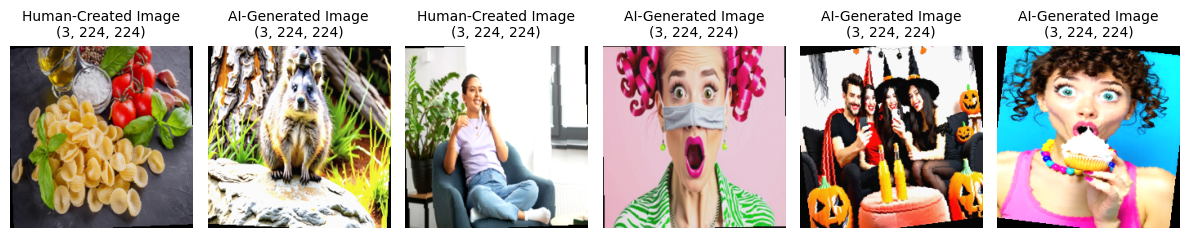

In [ ]:
display_random_images(train_dataset,
                      class_to_idx=class_dict,
                      n=6,
                      display_shape=True,
                      seed=None
  )

### 3.4 Turn custom loaded images into Dataloaders

In [ ]:
def custom_collate_fn(batch, target_size=(224, 224)):
    spatial_imgs, freq_imgs, labels = zip(*batch)

    # Stack spatial images (should already be same size from transform)
    spatial_imgs = torch.stack(spatial_imgs)

    # Resize frequency images to the target size
    freq_imgs_resized = []
    for img in freq_imgs:
        if img.shape[-2:] != target_size:
            img = img.unsqueeze(0)  # Add batch dim
            img = F.interpolate(img, size=target_size, mode='bilinear', align_corners=False)
            img = img.squeeze(0)
        freq_imgs_resized.append(img)

    freq_imgs = torch.stack(freq_imgs_resized)
    labels = torch.tensor(labels)

    return spatial_imgs, freq_imgs, labels

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = 1

train_dataloader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    collate_fn=lambda batch: custom_collate_fn(batch, target_size=(224, 224))
)


eval_dataloader = DataLoader(
    dataset=eval_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
)
print(len(eval_dataloader), 500*32, len(train_dataloader))
train_dataloader, eval_dataloader,

500 16000 1999


(<torch.utils.data.dataloader.DataLoader at 0x7c726579eb50>,
 <torch.utils.data.dataloader.DataLoader at 0x7c72657bcd90>)

In [ ]:
#mini subsets of dataloaders for experimentation
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = 1

train_dataloader_mini = DataLoader(
    train_dataset_mini,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    collate_fn=lambda batch: custom_collate_fn(batch, target_size=(224, 224))
)


eval_dataloader_mini = DataLoader(
    dataset=eval_dataset_mini,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
)

train_dataloader_mini, eval_dataloader_mini, len(train_dataloader_mini), len(eval_dataloader_mini)

(<torch.utils.data.dataloader.DataLoader at 0x7c72657bd490>,
 80,
 20)

In [ ]:
spatial, frequency, labels = next(iter(train_dataloader))
spatial.shape, frequency.shape, labels.shape

(torch.Size([32, 3, 224, 224]),
 torch.Size([32, 1, 224, 224]),
 torch.Size([32]))

### 3.5 visualize n images of the spatial branch and frequency branch

In [ ]:
def show_spatial_and_frequency(spatial_batch, frequency_batch, labels, class_dict, n=5):

    """
    visualize n images of the spatial branch and frequency branch
    """
    plt.figure(figsize=(n * 3, 6))

    for i in range(n):
        # Spatial image
        plt.subplot(2, n, i + 1)
        img = spatial_batch[i].permute(1, 2, 0)  # CxHxW → HxWxC
        img = img * 0.5 + 0.5  # Undo normalization [-1,1] → [0,1]
        plt.imshow(img)
        label_idx = int(labels[i])
        plt.title(f"Spatial\nLabel: {class_dict[label_idx]}")
        plt.axis("off")

        # Frequency image (magnitude only)
        plt.subplot(2, n, i + 1 + n)
        freq_img = frequency_batch[i]
        if freq_img.ndim == 3:
            freq_img = freq_img.mean(dim=0)  # Convert to single channel
        freq_img = freq_img / freq_img.max()  # Normalize for display
        plt.imshow(freq_img.cpu(), cmap="inferno")
        plt.title("Frequency")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

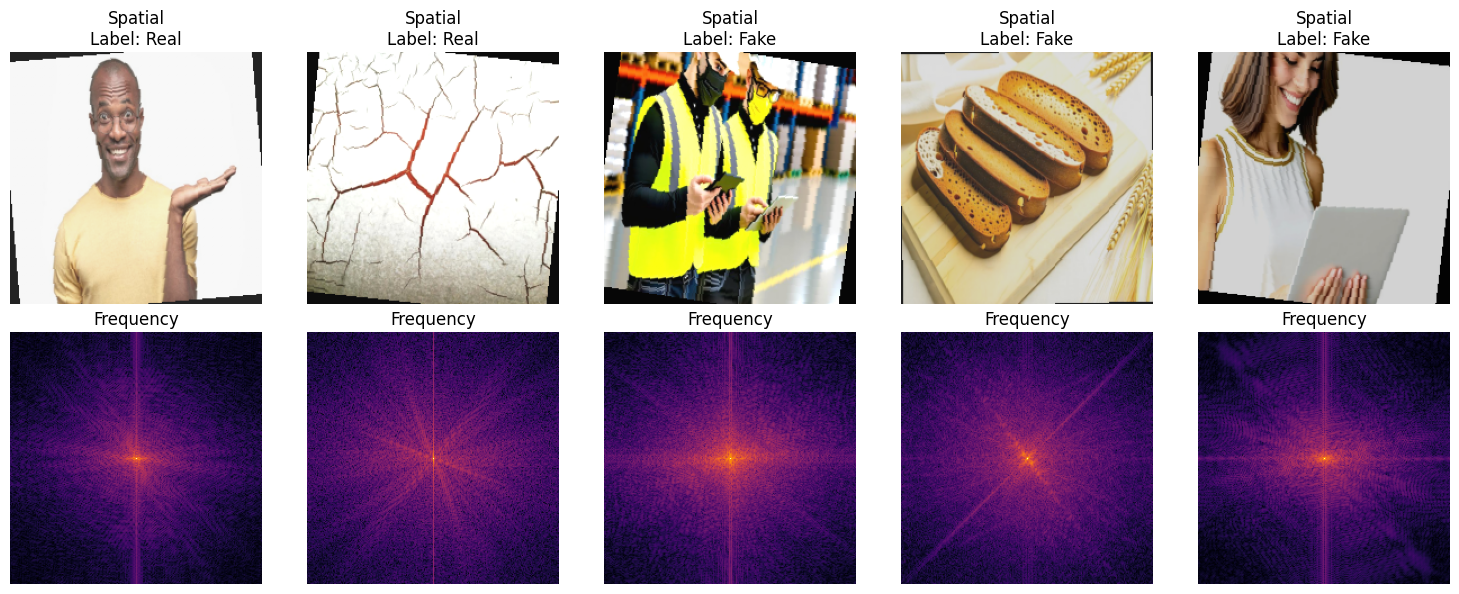

In [ ]:
spatial_batch, frequency_batch, labels = next(iter(train_dataloader))
class_dict = {
    0: "Real",
    1: "Fake"
}
show_spatial_and_frequency(spatial_batch, frequency_batch, labels, class_dict, n=5)

## 4. Model 0: Hybrid Architecture

> Which integrate: **spatial branch** + **efrequency branch**.
> Combined via an attention-based fusion module. Followed by adversarial discriminator added.


### 4.1 Spatial Branch
The spatial branch employs a convolutional neural network (CNN) to extract discriminative features from the raw image.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SpatialBranch(nn.Module):
    def __init__(self, input_channels: int = 3, output_channels: int = 1):
        super(SpatialBranch, self).__init__()

        # Convolutional layers to process the spatial domain image
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

        # Batch normalization and pooling
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers for final prediction
        self.fc1 = nn.Linear(256 * 28 * 28, 1024)  # Adjust based on input size
        self.fc2 = nn.Linear(1024, output_channels)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # Output layer
        return x

### 4.2 Frequency Branch

The frequency branch processes the Fourier-transformed image to capture global periodic artifacts characteristic of AI-generated content.

In [ ]:
class FrequencyBranch(nn.Module):
    def __init__(self, input_channels: int = 1, output_channels: int = 1):
        super(FrequencyBranch, self).__init__()

        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(256 * 28 * 28, 1024)
        self.fc2 = nn.Linear(1024, output_channels)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### 4.3 Attention-based fusion module

An attention-based fusion module then combines these heterogeneous features to form a robust representation.

In [ ]:
class AttentionFusionModule(nn.Module):
    def __init__(self, input_size: int, output_size: int):
        super(AttentionFusionModule, self).__init__()

        # Attention weights (to learn the importance of each branch's output)
        self.attention_weight_spatial = nn.Parameter(torch.randn(input_size))
        self.attention_weight_frequency = nn.Parameter(torch.randn(input_size))

        self.fc1 = nn.Linear(input_size * 2, output_size)  # Output size is adjustable
        self.fc2 = nn.Linear(output_size, 1)  # Output a single value (real or fake)

    def forward(self, spatial_features, frequency_features):
        # Apply attention to both spatial and frequency features
        spatial_weighted = spatial_features * torch.sigmoid(self.attention_weight_spatial)
        frequency_weighted = frequency_features * torch.sigmoid(self.attention_weight_frequency)

        # Concatenate weighted features
        combined_features = torch.cat((spatial_weighted, frequency_weighted), dim=1)

        # Flatten the output from attention and pass through fully connected layers
        x = F.relu(self.fc1(combined_features))
        x = self.fc2(x)  # Output the prediction
        return x

### 4.4 Adversarial training

Gradient Reversal Layer + Domain Discriminator + Integration into training loop

#### 4.4.1 Gradient Reversal Layer

In [ ]:
class GradientReversalLayer(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.view_as(x)  # No change to the input, just passing through

    @staticmethod
    def backward(ctx, grad_output):
        grad_input = grad_output.neg() * ctx.lambda_
        return grad_input, None  # lambda_ is not used in the backward pass

#### 4.4.2 Adversarial Discriminator

In [ ]:
class AdversarialDiscriminator(nn.Module):
    def __init__(self, input_size: int):
        super(AdversarialDiscriminator, self).__init__()

        self.fc1 = nn.Linear(input_size, 1024)  # Input size after fusion
        self.fc2 = nn.Linear(1024, 1)  # Output: real or fake

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))  # Output a probability (0 or 1)
        return x

class DiscriminatorWithGRL(nn.Module):
    def __init__(self, input_size=128, lambda_=1.0):
        super(DiscriminatorWithGRL, self).__init__()
        self.lambda_ = lambda_
        self.grl = GradientReversalLayer.apply
        self.discriminator = AdversarialDiscriminator(input_size)

    def forward(self, x):
        # Apply GRL to the features before passing to the discriminator
        x = self.grl(x, self.lambda_)
        return self.discriminator(x)

### 4.5 Assemble the Final Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function

# --- GRL (Keep as is) ---
class GradientReversalLayerFn(Function):
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        grad_input = grad_output.neg() * ctx.lambda_
        return grad_input, None

# --- Base Feature Extractor (Used by Spatial and Frequency) ---
class BaseFeatureExtractor(nn.Module):
    def __init__(self, input_channels, feature_dim=256): # Smaller feature_dim example
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2) # 224 -> 112

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2) # 112 -> 56

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2) # 56 -> 28

        # Adaptive pooling for robustness to input size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * 1 * 1, feature_dim) # Output fixed feature dim
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1) # Flatten
        x = self.dropout(F.relu(self.fc(x))) # Return features
        return x

class SpatialBranch(BaseFeatureExtractor):
    def __init__(self, feature_dim=256):
        super().__init__(input_channels=3, feature_dim=feature_dim)

class FrequencyBranch(BaseFeatureExtractor):
    def __init__(self, feature_dim=256):
        super().__init__(input_channels=1, feature_dim=feature_dim)


# --- Attention Fusion (Now includes final classification) ---
class AttentionFusionModule(nn.Module):
    def __init__(self, feature_dim: int, hidden_dim: int = 128):
        super().__init__()
        self.feature_dim = feature_dim
        # Simple gating attention (as before, consider alternatives if needed)
        self.att_weight_spatial = nn.Parameter(torch.ones(feature_dim)) # Init with ones
        self.att_weight_freq = nn.Parameter(torch.ones(feature_dim)) # Init with ones

        self.fc1 = nn.Linear(feature_dim * 2, hidden_dim)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_dim, 1) # Final classification layer

    def forward(self, spatial_features, frequency_features):
        # Apply simple gating/attention
        att_s = torch.sigmoid(self.att_weight_spatial)
        att_f = torch.sigmoid(self.att_weight_freq)
        spatial_weighted = spatial_features * att_s
        frequency_weighted = frequency_features * att_f

        # Concatenate
        combined_features = torch.cat((spatial_weighted, frequency_weighted), dim=1)

        # Pass through MLP for classification
        x = self.dropout(F.relu(self.fc1(combined_features)))
        output = self.fc2(x) # Logits for main task (real/fake)

        # Return logits AND the features just before the final layer for potential GRL use
        return output, x # Return main task output (logits) and intermediate features


# --- Adversarial Discriminator (For Domain Classification) ---
class AdversarialDiscriminator(nn.Module):
    def __init__(self, input_size: int, hidden_dim: int = 64): # Smaller discriminator
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1) # Output: domain label (e.g., generator ID)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # Output logits for domain classification
        return x


# --- Hybrid Model integrating all parts ---
class HybridModel(nn.Module):
    def __init__(self, feature_dim=256, fusion_hidden_dim=128, disc_hidden_dim=64, lambda_grl=1.0):
        super().__init__()
        self.spatial_branch = SpatialBranch(feature_dim)
        self.frequency_branch = FrequencyBranch(feature_dim)
        self.attention_fusion = AttentionFusionModule(feature_dim, fusion_hidden_dim)

        # Domain discriminator applied to features *before* final classification layer
        self.domain_discriminator = AdversarialDiscriminator(fusion_hidden_dim, disc_hidden_dim)
        self.lambda_grl = lambda_grl

    def forward(self, spatial_input, frequency_input):
        spatial_features = self.spatial_branch(spatial_input)
        frequency_features = self.frequency_branch(frequency_input)

        # Fuse features and get main prediction + intermediate features
        main_task_output, intermediate_features = self.attention_fusion(spatial_features, frequency_features)

        # Apply GRL and domain discriminator to intermediate features
        reversed_features = GradientReversalLayerFn.apply(intermediate_features, self.lambda_grl)
        domain_task_output = self.domain_discriminator(reversed_features)

        # Return both outputs for separate loss calculation during training
        return main_task_output, domain_task_output

# --- Example Usage (Corrected) ---
feature_dim = 256
fusion_hidden_dim = 128

# Example input data (spatial image, frequency image)
spatial_input = torch.randn(4, 3, 224, 224)  # Batch of 4 spatial images
frequency_input = torch.randn(4, 1, 224, 224) # Batch of 4 frequency images (ensure same H, W)

# Create the full hybrid model
hybrid_model = HybridModel(feature_dim=feature_dim, fusion_hidden_dim=fusion_hidden_dim, lambda_grl=1.0)

# Get the model outputs
main_output, domain_output = hybrid_model(spatial_input, frequency_input)

print("Main Task Output Shape:", main_output.shape) # Should be [batch_size, 1] (logits)
print("Domain Task Output Shape:", domain_output.shape) # Should be [batch_size, 1] (logits)

Main Task Output Shape: torch.Size([4, 1])
Domain Task Output Shape: torch.Size([4, 1])


In [ ]:
# Loss
criterion_classification = nn.BCEWithLogitsLoss()
criterion_adversarial = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = torch.optim.SGD(hybrid_model.parameters(), lr=0.001, momentum=0.9)

## 5. Training loop

### 5.1 Train model

In [ ]:
from tqdm.auto import tqdm

import torch

def save_checkpoint(model, optimizer, epoch, batch_idx, loss, filename="checkpoint.pth"):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'batch_idx': batch_idx,
        'loss': loss,
    }
    torch.save(checkpoint, filename)

def train_one_epoch(model, dataloader, optimizer, criterion_cls, criterion_adv, device, epoch, lambda_adv=1.0):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (spatial_imgs, frequency_imgs, labels) in tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch + 1}", unit="batch"):
        spatial_imgs = spatial_imgs.to(device)
        frequency_imgs = frequency_imgs.to(device)
        labels = labels.float().to(device)
        domain_labels = labels.clone()  # Now same as labels

        optimizer.zero_grad()

        class_output, adv_output = model(spatial_imgs, frequency_imgs)

        # Debug only for first batch
        if batch_idx == 0:
            print(f"[Epoch {epoch}] Sample Spatial Input Shape: {spatial_imgs.shape}")
            print(f"[Epoch {epoch}] class_output sample: {class_output[0].detach().cpu()}")
            print(f"[Epoch {epoch}] adv_output sample: {adv_output[0].detach().cpu()}")

        # Check for NaNs
        if torch.isnan(class_output).any() or torch.isinf(class_output).any():
            print(f"[Epoch {epoch}] NaN/Inf in class_output at batch {batch_idx}")
            continue

        loss_cls = criterion_cls(class_output.view(-1), labels)
        loss_adv = criterion_adv(adv_output.view(-1), domain_labels)
        loss = loss_cls + lambda_adv * loss_adv

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Accuracy
        preds = (torch.sigmoid(class_output) > 0.5).float()
        correct += (preds.view(-1) == labels).sum().item()
        total += labels.size(0)

        if batch_idx % 5 == 0:
            print(f"[Batch {batch_idx}] Loss: {loss.item():.4f} Acc: {correct/total:.4f}")
            save_checkpoint(model, optimizer, epoch, batch_idx, loss, filename="checkpoint.pth")

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct / total
    print(f"\n[Epoch {epoch} training Summary] Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}\n")

    return epoch_loss, epoch_acc

In [ ]:
train_one_epoch(
    model=hybrid_model,
    dataloader=train_dataloader_mini,
    optimizer=optimizer,
    criterion_cls=criterion_classification,
    criterion_adv=criterion_adversarial,
    device=device,
    epoch=1,
    lambda_adv=1.0
)

0it [00:00, ?it/s]

[Epoch 1] Sample Spatial Input Shape: torch.Size([32, 3, 224, 224])
[Epoch 1] class_output sample: tensor([-0.0337])
[Epoch 1] adv_output sample: tensor([-0.0318])
[Epoch 1][Batch 0] Loss: 1.3937 Acc: 0.5000
[Epoch 1][Batch 5] Loss: 1.3670 Acc: 0.5573
[Epoch 1][Batch 10] Loss: 1.3794 Acc: 0.5682
[Epoch 1][Batch 15] Loss: 1.3789 Acc: 0.5859
[Epoch 1][Batch 20] Loss: 1.3756 Acc: 0.5818
[Epoch 1][Batch 25] Loss: 1.3871 Acc: 0.5697
[Epoch 1][Batch 30] Loss: 1.3675 Acc: 0.5746
[Epoch 1][Batch 35] Loss: 1.3589 Acc: 0.5799
[Epoch 1][Batch 40] Loss: 1.3675 Acc: 0.5808
[Epoch 1][Batch 45] Loss: 1.3604 Acc: 0.5883
[Epoch 1][Batch 50] Loss: 1.3611 Acc: 0.5913
[Epoch 1][Batch 55] Loss: 1.3537 Acc: 0.5949
[Epoch 1][Batch 60] Loss: 1.3446 Acc: 0.6055
[Epoch 1][Batch 65] Loss: 1.3736 Acc: 0.6084
[Epoch 1][Batch 70] Loss: 1.3513 Acc: 0.6136
[Epoch 1][Batch 75] Loss: 1.3286 Acc: 0.6184

[Epoch 1 Summary] Loss: 1.3688, Accuracy: 0.6212



In [ ]:
train_one_epoch(
    model=hybrid_model,
    dataloader=train_dataloader_mini,
    optimizer=optimizer,
    criterion_cls=criterion_classification,
    criterion_adv=criterion_adversarial,
    device=device,
    epoch=2,
    lambda_adv=1.0
)

0it [00:00, ?it/s]

[Epoch 2] Sample Spatial Input Shape: torch.Size([32, 3, 224, 224])
[Epoch 2] class_output sample: tensor([-0.3076])
[Epoch 2] adv_output sample: tensor([-0.0136])
[Epoch 2][Batch 0] Loss: 1.3494 Acc: 0.7188
[Epoch 2][Batch 5] Loss: 1.3268 Acc: 0.6458
[Epoch 2][Batch 10] Loss: 1.3369 Acc: 0.6903
[Epoch 2][Batch 15] Loss: 1.3773 Acc: 0.6855
[Epoch 2][Batch 20] Loss: 1.2994 Acc: 0.7024
[Epoch 2][Batch 25] Loss: 1.3284 Acc: 0.7127
[Epoch 2][Batch 30] Loss: 1.2958 Acc: 0.7238
[Epoch 2][Batch 35] Loss: 1.3050 Acc: 0.7248
[Epoch 2][Batch 40] Loss: 1.3191 Acc: 0.7317
[Epoch 2][Batch 45] Loss: 1.3112 Acc: 0.7337
[Epoch 2][Batch 50] Loss: 1.3149 Acc: 0.7341
[Epoch 2][Batch 55] Loss: 1.2956 Acc: 0.7338
[Epoch 2][Batch 60] Loss: 1.3326 Acc: 0.7346
[Epoch 2][Batch 65] Loss: 1.2699 Acc: 0.7401
[Epoch 2][Batch 70] Loss: 1.3236 Acc: 0.7390
[Epoch 2][Batch 75] Loss: 1.2723 Acc: 0.7418

[Epoch 2 Summary] Loss: 1.3225, Accuracy: 0.7435



In [ ]:
train_one_epoch(
    model=hybrid_model,
    dataloader=train_dataloader_mini,
    optimizer=optimizer,
    criterion_cls=criterion_classification,
    criterion_adv=criterion_adversarial,
    device=device,
    epoch=3,
    lambda_adv=1.0
)

0it [00:00, ?it/s]

[Epoch 3] Sample Spatial Input Shape: torch.Size([32, 3, 224, 224])
[Epoch 3] class_output sample: tensor([-0.2632])
[Epoch 3] adv_output sample: tensor([0.0553])
[Epoch 3][Batch 0] Loss: 1.3449 Acc: 0.7188
[Epoch 3][Batch 5] Loss: 1.3245 Acc: 0.6979
[Epoch 3][Batch 10] Loss: 1.3054 Acc: 0.7017
[Epoch 3][Batch 15] Loss: 1.2868 Acc: 0.7207
[Epoch 3][Batch 20] Loss: 1.3117 Acc: 0.7232
[Epoch 3][Batch 25] Loss: 1.2454 Acc: 0.7248
[Epoch 3][Batch 30] Loss: 1.1811 Acc: 0.7339
[Epoch 3][Batch 35] Loss: 1.3464 Acc: 0.7292
[Epoch 3][Batch 40] Loss: 1.2685 Acc: 0.7287
[Epoch 3][Batch 45] Loss: 1.1826 Acc: 0.7351
[Epoch 3][Batch 50] Loss: 1.2944 Acc: 0.7341
[Epoch 3][Batch 55] Loss: 1.2494 Acc: 0.7344
[Epoch 3][Batch 60] Loss: 1.2075 Acc: 0.7382
[Epoch 3][Batch 65] Loss: 1.2348 Acc: 0.7382
[Epoch 3][Batch 70] Loss: 1.2657 Acc: 0.7394
[Epoch 3][Batch 75] Loss: 1.1851 Acc: 0.7434

[Epoch 3 Summary] Loss: 1.2667, Accuracy: 0.7463



### 5.2 Eval model

In [ ]:
def eval_one_epoch(model, dataloader, criterion_cls, device, epoch):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (spatial_imgs, frequency_imgs, labels) in tqdm(enumerate(dataloader),
                                                              total=len(dataloader),
                                                              desc=f"Eval Epoch {epoch}",
                                                              unit="batch"):
            spatial_imgs = spatial_imgs.to(device)
            frequency_imgs = frequency_imgs.to(device)
            labels = labels.float().to(device)

            class_output, _ = model(spatial_imgs, frequency_imgs)

            loss_cls = criterion_cls(class_output.view(-1), labels)
            running_loss += loss_cls.item()

            preds = (torch.sigmoid(class_output) > 0.5).float()
            correct += (preds.view(-1) == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct / total
    print(f"[Epoch {epoch} | Evaluation] Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}%\n")

    return epoch_loss, epoch_acc

### 5.3 train and eval model and save best model

In [ ]:
from tqdm.auto import tqdm
import copy
import torch

def train_model(model: torch.nn.Module,
                train_dataloader,
                val_dataloader,
                optimizer,
                criterion_cls,
                criterion_adv,
                epochs: int,
                device: torch.device,
                lambda_adv: float = 1.0,
                start_epoch: int = 0):

    best_val_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    results = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }

    for epoch in tqdm(range(start_epoch, start_epoch + epochs), desc="Training Progress"):
        # Training step
        train_loss, train_acc = train_one_epoch(
            model=model,
            dataloader=train_dataloader,
            optimizer=optimizer,
            criterion_cls=criterion_cls,
            criterion_adv=criterion_adv,
            device=device,
            epoch=epoch,
            lambda_adv=lambda_adv
        )

        # Evaluation step
        val_loss, val_acc = eval_one_epoch(
            model=model,
            dataloader=val_dataloader,
            criterion_cls=criterion_cls,
            device=device,
            epoch=epoch
        )

        # Save best model based on validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), "best_hybrid_model.pth")
            print(f"Saved new best model at epoch {epoch} with val acc: {val_acc:.4f}")

        # Save regular checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            torch.save(model.state_dict(), f"checkpoint_epoch_{epoch+1}.pth")
            print(f"Saved checkpoint at epoch {epoch+1}")

        # Append results
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

    # Load best model weights at the end
    model.load_state_dict(best_model_wts)

    return results

### 5.4 training on a small subset of dataset

In [ ]:
from timeit import default_timer as timer

# 1. Set seeds for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# 2. Define training hyperparameters
NUM_EPOCHS = 3
LEARNING_RATE = 0.001
LAMBDA_ADV = 0.5  # weight for adversarial loss

# 3. Instantiate your hybrid model and move to device
hybrid_model = HybridModel(feature_dim=feature_dim, fusion_hidden_dim=fusion_hidden_dim, lambda_grl=1.0).to(device)

# 4. Define loss functions
criterion_cls = nn.BCEWithLogitsLoss()      # Binary classification loss
criterion_adv = nn.BCEWithLogitsLoss()      # Domain/adversarial loss

# 5. Optimizer
optimizer = torch.optim.SGD(hybrid_model.parameters(), lr=LEARNING_RATE, momentum=0.9)

# 6. Define accuracy metric
def acc_fn(y_true, y_pred):
    y_pred_label = (torch.sigmoid(y_pred) > 0.5).float()
    correct = torch.eq(y_true.view(-1), y_pred_label.view(-1)).sum().item()
    return correct / len(y_true)

# 7. Start training timer
start_time = timer()

# 8. Train the model
results = train_model(model=hybrid_model,
                      train_dataloader=train_dataloader_mini,
                      val_dataloader=eval_dataloader_mini,
                      optimizer=optimizer,
                      criterion_cls=criterion_cls,
                      criterion_adv=criterion_adv,
                      epochs=NUM_EPOCHS,
                      device=device,
                      lambda_adv=LAMBDA_ADV)

# 9. End timer and print duration
end_time = timer()
print(f"Total training time: {end_time - start_time:.2f} seconds.")

Training Progress:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0:   0%|          | 0/80 [00:00<?, ?batch/s]

[Epoch 0] Sample Spatial Input Shape: torch.Size([32, 3, 224, 224])
[Epoch 0] class_output sample: tensor([0.0136])
[Epoch 0] adv_output sample: tensor([0.0574])
[Batch 0] Loss: 1.0385 Acc: 0.4688
[Batch 5] Loss: 1.0626 Acc: 0.4062
[Batch 10] Loss: 1.0308 Acc: 0.4517
[Batch 15] Loss: 1.0404 Acc: 0.4609
[Batch 20] Loss: 1.0348 Acc: 0.4762
[Batch 25] Loss: 1.0347 Acc: 0.4904
[Batch 30] Loss: 1.0201 Acc: 0.5101
[Batch 35] Loss: 0.9989 Acc: 0.5234
[Batch 40] Loss: 1.0144 Acc: 0.5312
[Batch 45] Loss: 1.0376 Acc: 0.5380
[Batch 50] Loss: 1.0230 Acc: 0.5441
[Batch 55] Loss: 1.0217 Acc: 0.5502
[Batch 60] Loss: 0.9997 Acc: 0.5610
[Batch 65] Loss: 0.9935 Acc: 0.5620
[Batch 70] Loss: 1.0008 Acc: 0.5731
[Batch 75] Loss: 1.0079 Acc: 0.5789

[Epoch 0 training Summary] Loss: 1.0226, Accuracy: 0.5790



Evaluating Epoch 0:   0%|          | 0/20 [00:00<?, ?batch/s]

[Epoch 0 | Evaluation] Loss: 0.6504 | Accuracy: 0.7047%

Saved new best model at epoch 0 with val acc: 0.7047


Epoch 1:   0%|          | 0/80 [00:00<?, ?batch/s]

[Epoch 1] Sample Spatial Input Shape: torch.Size([32, 3, 224, 224])
[Epoch 1] class_output sample: tensor([-0.1467])
[Epoch 1] adv_output sample: tensor([0.0504])
[Batch 0] Loss: 1.0087 Acc: 0.7188
[Batch 5] Loss: 1.0080 Acc: 0.6094
[Batch 10] Loss: 0.9899 Acc: 0.6392
[Batch 15] Loss: 1.0393 Acc: 0.6328
[Batch 20] Loss: 0.9999 Acc: 0.6384
[Batch 25] Loss: 0.9580 Acc: 0.6478
[Batch 30] Loss: 0.9670 Acc: 0.6603
[Batch 35] Loss: 0.9857 Acc: 0.6615
[Batch 40] Loss: 0.9496 Acc: 0.6684
[Batch 45] Loss: 0.9539 Acc: 0.6739
[Batch 50] Loss: 1.0213 Acc: 0.6771
[Batch 55] Loss: 0.9647 Acc: 0.6819
[Batch 60] Loss: 0.9913 Acc: 0.6860
[Batch 65] Loss: 0.9824 Acc: 0.6903
[Batch 70] Loss: 0.9864 Acc: 0.6941
[Batch 75] Loss: 0.9333 Acc: 0.6978

[Epoch 1 training Summary] Loss: 0.9831, Accuracy: 0.7002



Evaluating Epoch 1:   0%|          | 0/20 [00:00<?, ?batch/s]

[Epoch 1 | Evaluation] Loss: 0.5856 | Accuracy: 0.7969%

Saved new best model at epoch 1 with val acc: 0.7969


Epoch 2:   0%|          | 0/80 [00:00<?, ?batch/s]

[Epoch 2] Sample Spatial Input Shape: torch.Size([32, 3, 224, 224])
[Epoch 2] class_output sample: tensor([-0.6701])
[Epoch 2] adv_output sample: tensor([0.0229])
[Batch 0] Loss: 0.9346 Acc: 0.7500
[Batch 5] Loss: 0.9676 Acc: 0.7292
[Batch 10] Loss: 0.9757 Acc: 0.7045
[Batch 15] Loss: 0.9933 Acc: 0.7090
[Batch 20] Loss: 0.9831 Acc: 0.7113
[Batch 25] Loss: 0.8879 Acc: 0.7284
[Batch 30] Loss: 0.9999 Acc: 0.7238
[Batch 35] Loss: 0.8673 Acc: 0.7309
[Batch 40] Loss: 0.8843 Acc: 0.7348
[Batch 45] Loss: 0.9419 Acc: 0.7371
[Batch 50] Loss: 0.9287 Acc: 0.7408
[Batch 55] Loss: 0.8746 Acc: 0.7467
[Batch 60] Loss: 0.8677 Acc: 0.7474
[Batch 65] Loss: 0.8972 Acc: 0.7509
[Batch 70] Loss: 0.9467 Acc: 0.7469
[Batch 75] Loss: 0.9163 Acc: 0.7504

[Epoch 2 training Summary] Loss: 0.9246, Accuracy: 0.7525



Evaluating Epoch 2:   0%|          | 0/20 [00:00<?, ?batch/s]

[Epoch 2 | Evaluation] Loss: 0.5016 | Accuracy: 0.8219%

Saved new best model at epoch 2 with val acc: 0.8219
Total training time: 898.09 seconds.


In [ ]:
# Continue training using saved dict

# 1. Load the saved weights
hybrid_model.load_state_dict(torch.load("best_hybrid_model.pth"))

NUM_EPOCHS = 5
START_EPOCH = 3  # epochs trained

# 7. Start training timer
start_time = timer()

results = train_model(model=hybrid_model,
                      train_dataloader=train_dataloader_mini,
                      val_dataloader=eval_dataloader_mini,
                      optimizer=optimizer,
                      criterion_cls=criterion_cls,
                      criterion_adv=criterion_adv,
                      epochs=NUM_EPOCHS,
                      device=device,
                      lambda_adv=LAMBDA_ADV,
                      start_epoch=START_EPOCH)

end_time = timer()
print(f"Total training time: {end_time - start_time:.2f} seconds.")

Training Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/80 [00:00<?, ?batch/s]

[Epoch 3] Sample Spatial Input Shape: torch.Size([32, 3, 224, 224])
[Epoch 3] class_output sample: tensor([1.1774])
[Epoch 3] adv_output sample: tensor([0.0357])
[Batch 0] Loss: 0.9011 Acc: 0.7500
[Batch 5] Loss: 0.9444 Acc: 0.7292
[Batch 10] Loss: 0.9649 Acc: 0.7614
[Batch 15] Loss: 0.8577 Acc: 0.7480
[Batch 20] Loss: 0.9059 Acc: 0.7619
[Batch 25] Loss: 0.9043 Acc: 0.7644
[Batch 30] Loss: 0.9210 Acc: 0.7661
[Batch 35] Loss: 1.0665 Acc: 0.7604
[Batch 40] Loss: 0.8975 Acc: 0.7614
[Batch 45] Loss: 0.7852 Acc: 0.7595
[Batch 50] Loss: 0.8708 Acc: 0.7598
[Batch 55] Loss: 0.7870 Acc: 0.7634
[Batch 60] Loss: 0.9136 Acc: 0.7638
[Batch 65] Loss: 0.8579 Acc: 0.7623
[Batch 70] Loss: 0.8420 Acc: 0.7592
[Batch 75] Loss: 0.7534 Acc: 0.7599

[Epoch 3 training Summary] Loss: 0.8698, Accuracy: 0.7631



Evaluating Epoch 3:   0%|          | 0/20 [00:00<?, ?batch/s]

[Epoch 3 | Evaluation] Loss: 0.4391 | Accuracy: 0.8172%

Saved new best model at epoch 3 with val acc: 0.8172


Epoch 4:   0%|          | 0/80 [00:00<?, ?batch/s]

[Epoch 4] Sample Spatial Input Shape: torch.Size([32, 3, 224, 224])
[Epoch 4] class_output sample: tensor([0.3599])
[Epoch 4] adv_output sample: tensor([0.0839])
[Batch 0] Loss: 0.8214 Acc: 0.8125
[Batch 5] Loss: 0.8211 Acc: 0.7292
[Batch 10] Loss: 0.7994 Acc: 0.7557
[Batch 15] Loss: 0.9788 Acc: 0.7598
[Batch 20] Loss: 0.7714 Acc: 0.7574
[Batch 25] Loss: 0.8834 Acc: 0.7476
[Batch 30] Loss: 0.8445 Acc: 0.7520
[Batch 35] Loss: 0.8627 Acc: 0.7622
[Batch 40] Loss: 0.7502 Acc: 0.7691
[Batch 45] Loss: 0.7819 Acc: 0.7629
[Batch 50] Loss: 0.8812 Acc: 0.7616
[Batch 55] Loss: 0.9311 Acc: 0.7623
[Batch 60] Loss: 0.9842 Acc: 0.7608
[Batch 65] Loss: 0.8262 Acc: 0.7633
[Batch 70] Loss: 0.8488 Acc: 0.7650
[Batch 75] Loss: 0.8394 Acc: 0.7636

[Epoch 4 training Summary] Loss: 0.8441, Accuracy: 0.7619



Evaluating Epoch 4:   0%|          | 0/20 [00:00<?, ?batch/s]

[Epoch 4 | Evaluation] Loss: 0.4087 | Accuracy: 0.8281%

Saved new best model at epoch 4 with val acc: 0.8281
Saved checkpoint at epoch 5


Epoch 5:   0%|          | 0/80 [00:00<?, ?batch/s]

[Epoch 5] Sample Spatial Input Shape: torch.Size([32, 3, 224, 224])
[Epoch 5] class_output sample: tensor([-0.0841])
[Epoch 5] adv_output sample: tensor([0.0226])
[Batch 0] Loss: 0.9926 Acc: 0.6562
[Batch 5] Loss: 0.8687 Acc: 0.7500
[Batch 10] Loss: 0.8455 Acc: 0.7472
[Batch 15] Loss: 0.7744 Acc: 0.7656
[Batch 20] Loss: 0.7231 Acc: 0.7857
[Batch 25] Loss: 0.8377 Acc: 0.7837
[Batch 30] Loss: 0.7847 Acc: 0.7843
[Batch 35] Loss: 0.7219 Acc: 0.7812
[Batch 40] Loss: 0.7207 Acc: 0.7866
[Batch 45] Loss: 0.8124 Acc: 0.7846
[Batch 50] Loss: 0.7135 Acc: 0.7800
[Batch 55] Loss: 0.8305 Acc: 0.7801
[Batch 60] Loss: 0.9081 Acc: 0.7761
[Batch 65] Loss: 0.7999 Acc: 0.7779
[Batch 70] Loss: 0.7245 Acc: 0.7777
[Batch 75] Loss: 0.7822 Acc: 0.7784

[Epoch 5 training Summary] Loss: 0.8106, Accuracy: 0.7740



Evaluating Epoch 5:   0%|          | 0/20 [00:00<?, ?batch/s]

[Epoch 5 | Evaluation] Loss: 0.3800 | Accuracy: 0.8469%

Saved new best model at epoch 5 with val acc: 0.8469


Epoch 6:   0%|          | 0/80 [00:00<?, ?batch/s]

[Epoch 6] Sample Spatial Input Shape: torch.Size([32, 3, 224, 224])
[Epoch 6] class_output sample: tensor([-1.4751])
[Epoch 6] adv_output sample: tensor([-0.0401])
[Batch 0] Loss: 0.7668 Acc: 0.7500
[Batch 5] Loss: 0.7988 Acc: 0.7708
[Batch 10] Loss: 0.8729 Acc: 0.7841
[Batch 15] Loss: 0.6615 Acc: 0.8066
[Batch 20] Loss: 0.9321 Acc: 0.7946
[Batch 25] Loss: 0.7486 Acc: 0.7957
[Batch 30] Loss: 0.7267 Acc: 0.7933
[Batch 35] Loss: 0.7313 Acc: 0.7891
[Batch 40] Loss: 0.7533 Acc: 0.7889
[Batch 45] Loss: 0.7810 Acc: 0.7894
[Batch 50] Loss: 0.9021 Acc: 0.7892
[Batch 55] Loss: 0.7537 Acc: 0.7824
[Batch 60] Loss: 0.6876 Acc: 0.7833
[Batch 65] Loss: 0.9087 Acc: 0.7836
[Batch 70] Loss: 0.8163 Acc: 0.7857
[Batch 75] Loss: 0.8029 Acc: 0.7854

[Epoch 6 training Summary] Loss: 0.7914, Accuracy: 0.7854



Evaluating Epoch 6:   0%|          | 0/20 [00:00<?, ?batch/s]

[Epoch 6 | Evaluation] Loss: 0.3708 | Accuracy: 0.8453%



Epoch 7:   0%|          | 0/80 [00:00<?, ?batch/s]

[Epoch 7] Sample Spatial Input Shape: torch.Size([32, 3, 224, 224])
[Epoch 7] class_output sample: tensor([-2.0705])
[Epoch 7] adv_output sample: tensor([0.1248])
[Batch 0] Loss: 0.7895 Acc: 0.7812
[Batch 5] Loss: 0.7803 Acc: 0.7917
[Batch 10] Loss: 0.8645 Acc: 0.7812
[Batch 15] Loss: 0.7338 Acc: 0.7793
[Batch 20] Loss: 0.7180 Acc: 0.7723
[Batch 25] Loss: 0.7445 Acc: 0.7704
[Batch 30] Loss: 0.8162 Acc: 0.7661
[Batch 35] Loss: 0.8164 Acc: 0.7717
[Batch 40] Loss: 0.7320 Acc: 0.7691
[Batch 45] Loss: 0.6445 Acc: 0.7792
[Batch 50] Loss: 0.6873 Acc: 0.7800
[Batch 55] Loss: 0.6261 Acc: 0.7835
[Batch 60] Loss: 0.7119 Acc: 0.7853
[Batch 65] Loss: 0.9132 Acc: 0.7831
[Batch 70] Loss: 0.7526 Acc: 0.7826
[Batch 75] Loss: 0.6483 Acc: 0.7858

[Epoch 7 training Summary] Loss: 0.7918, Accuracy: 0.7866



Evaluating Epoch 7:   0%|          | 0/20 [00:00<?, ?batch/s]

[Epoch 7 | Evaluation] Loss: 0.3730 | Accuracy: 0.8438%

Total training time: 293.40 seconds.


In [ ]:
from timeit import default_timer as timer

# Continue training using saved dict
saved_dict_path = "/content/drive/MyDrive/AI_Project_Data/checkpoint.pth"

# Load the checkpoint, which contains the full saved model state
checkpoint = torch.load(saved_dict_path)

# Extract the model weights and load them into the model
hybrid_model.load_state_dict(checkpoint['model_state_dict'])

# Optionally, load optimizer and other values if you need to continue training
# If not continuing training, skip this:
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
START_EPOCH = checkpoint['epoch'] + 1  # continue from the next epoch
# Loss
criterion_cls = nn.BCEWithLogitsLoss()
criterion_adv = nn.BCEWithLogitsLoss()


# Move the model to the correct device (if necessary)
hybrid_model.to(device)

NUM_EPOCHS = 5
START_EPOCH = 8  # epochs trained
LAMBDA_ADV = 0.5

# 7. Start training timer
start_time = timer()

results = train_model(model=hybrid_model,
                      train_dataloader=train_dataloader_mini,
                      val_dataloader=eval_dataloader_mini,
                      optimizer=optimizer,
                      criterion_cls=criterion_cls,
                      criterion_adv=criterion_adv,
                      epochs=NUM_EPOCHS,
                      device=device,
                      lambda_adv=LAMBDA_ADV,
                      start_epoch=START_EPOCH)

end_time = timer()
print(f"Total training time: {end_time - start_time:.2f} seconds.")

Training Progress:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 9:   0%|          | 0/80 [00:00<?, ?batch/s]

[Epoch 8] Sample Spatial Input Shape: torch.Size([32, 3, 224, 224])
[Epoch 8] class_output sample: tensor([0.0195])
[Epoch 8] adv_output sample: tensor([0.0263])
[Batch 0] Loss: 0.9968 Acc: 0.7188
[Batch 5] Loss: 0.9794 Acc: 0.6771
[Batch 10] Loss: 1.0070 Acc: 0.6676
[Batch 15] Loss: 0.9962 Acc: 0.6797
[Batch 20] Loss: 0.9685 Acc: 0.6771
[Batch 25] Loss: 0.9936 Acc: 0.6863
[Batch 30] Loss: 0.9988 Acc: 0.6794
[Batch 35] Loss: 0.9951 Acc: 0.6745
[Batch 40] Loss: 0.9951 Acc: 0.6852
[Batch 45] Loss: 0.9810 Acc: 0.6861
[Batch 50] Loss: 0.9742 Acc: 0.6869
[Batch 55] Loss: 1.0050 Acc: 0.6897
[Batch 60] Loss: 0.9722 Acc: 0.6906
[Batch 65] Loss: 0.9239 Acc: 0.6960
[Batch 70] Loss: 1.0161 Acc: 0.6928
[Batch 75] Loss: 0.9598 Acc: 0.6945

[Epoch 8 training Summary] Loss: 0.9900, Accuracy: 0.6900



Eval Epoch 8:   0%|          | 0/20 [00:00<?, ?batch/s]

[Epoch 8 | Evaluation] Loss: 0.5924 | Accuracy: 0.7969%

Saved new best model at epoch 8 with val acc: 0.7969


Epoch 10:   0%|          | 0/80 [00:00<?, ?batch/s]

[Epoch 9] Sample Spatial Input Shape: torch.Size([32, 3, 224, 224])
[Epoch 9] class_output sample: tensor([0.2068])
[Epoch 9] adv_output sample: tensor([0.0072])
[Batch 0] Loss: 0.9605 Acc: 0.7500
[Batch 5] Loss: 0.9633 Acc: 0.7292
[Batch 10] Loss: 0.9679 Acc: 0.7386
[Batch 15] Loss: 0.9537 Acc: 0.7227
[Batch 20] Loss: 0.9557 Acc: 0.7351
[Batch 25] Loss: 0.9525 Acc: 0.7380
[Batch 30] Loss: 0.9523 Acc: 0.7369
[Batch 35] Loss: 0.9231 Acc: 0.7396
[Batch 40] Loss: 0.9964 Acc: 0.7386
[Batch 45] Loss: 0.9319 Acc: 0.7405
[Batch 50] Loss: 0.9260 Acc: 0.7408
[Batch 55] Loss: 0.9759 Acc: 0.7416
[Batch 60] Loss: 0.8721 Acc: 0.7423
[Batch 65] Loss: 0.9092 Acc: 0.7457
[Batch 70] Loss: 0.9061 Acc: 0.7500
[Batch 75] Loss: 0.9347 Acc: 0.7475

[Epoch 9 training Summary] Loss: 0.9378, Accuracy: 0.7490



Eval Epoch 9:   0%|          | 0/20 [00:00<?, ?batch/s]

[Epoch 9 | Evaluation] Loss: 0.5155 | Accuracy: 0.8141%

Saved new best model at epoch 9 with val acc: 0.8141
Saved checkpoint at epoch 10


Epoch 11:   0%|          | 0/80 [00:00<?, ?batch/s]

[Epoch 10] Sample Spatial Input Shape: torch.Size([32, 3, 224, 224])
[Epoch 10] class_output sample: tensor([0.3566])
[Epoch 10] adv_output sample: tensor([0.0687])
[Batch 0] Loss: 0.8723 Acc: 0.8125
[Batch 5] Loss: 0.8917 Acc: 0.7865
[Batch 10] Loss: 0.8971 Acc: 0.7670
[Batch 15] Loss: 0.8966 Acc: 0.7637
[Batch 20] Loss: 0.8339 Acc: 0.7649
[Batch 25] Loss: 0.8198 Acc: 0.7620
[Batch 30] Loss: 0.8778 Acc: 0.7661
[Batch 35] Loss: 0.8444 Acc: 0.7674
[Batch 40] Loss: 0.9379 Acc: 0.7668
[Batch 45] Loss: 0.9385 Acc: 0.7711
[Batch 50] Loss: 0.9162 Acc: 0.7684
[Batch 55] Loss: 0.8362 Acc: 0.7673
[Batch 60] Loss: 0.8936 Acc: 0.7695
[Batch 65] Loss: 0.7772 Acc: 0.7685
[Batch 70] Loss: 0.8561 Acc: 0.7667
[Batch 75] Loss: 0.8503 Acc: 0.7660

[Epoch 10 training Summary] Loss: 0.8837, Accuracy: 0.7662



Eval Epoch 10:   0%|          | 0/20 [00:00<?, ?batch/s]

[Epoch 10 | Evaluation] Loss: 0.4482 | Accuracy: 0.8203%

Saved new best model at epoch 10 with val acc: 0.8203


Epoch 12:   0%|          | 0/80 [00:00<?, ?batch/s]

[Epoch 11] Sample Spatial Input Shape: torch.Size([32, 3, 224, 224])
[Epoch 11] class_output sample: tensor([-0.3395])
[Epoch 11] adv_output sample: tensor([-0.0576])
[Batch 0] Loss: 0.8303 Acc: 0.7812
[Batch 5] Loss: 0.8913 Acc: 0.7708
[Batch 10] Loss: 0.7772 Acc: 0.7898
[Batch 15] Loss: 0.8588 Acc: 0.7852
[Batch 20] Loss: 0.8593 Acc: 0.7753
[Batch 25] Loss: 0.8529 Acc: 0.7644
[Batch 30] Loss: 0.9663 Acc: 0.7571
[Batch 35] Loss: 0.7892 Acc: 0.7648
[Batch 40] Loss: 0.8027 Acc: 0.7660
[Batch 45] Loss: 0.8301 Acc: 0.7643
[Batch 50] Loss: 0.9521 Acc: 0.7696
[Batch 55] Loss: 0.7174 Acc: 0.7706
[Batch 60] Loss: 0.8391 Acc: 0.7736
[Batch 65] Loss: 0.7376 Acc: 0.7746
[Batch 70] Loss: 0.8368 Acc: 0.7777
[Batch 75] Loss: 1.0345 Acc: 0.7722

[Epoch 11 training Summary] Loss: 0.8402, Accuracy: 0.7694



Eval Epoch 11:   0%|          | 0/20 [00:00<?, ?batch/s]

[Epoch 11 | Evaluation] Loss: 0.4057 | Accuracy: 0.8328%

Saved new best model at epoch 11 with val acc: 0.8328


Epoch 13:   0%|          | 0/80 [00:00<?, ?batch/s]

[Epoch 12] Sample Spatial Input Shape: torch.Size([32, 3, 224, 224])
[Epoch 12] class_output sample: tensor([0.1947])
[Epoch 12] adv_output sample: tensor([0.0326])
[Batch 0] Loss: 0.8982 Acc: 0.6875
[Batch 5] Loss: 0.8783 Acc: 0.7760
[Batch 10] Loss: 0.8049 Acc: 0.7784
[Batch 15] Loss: 0.8331 Acc: 0.7812
[Batch 20] Loss: 0.8149 Acc: 0.7857
[Batch 25] Loss: 0.6731 Acc: 0.7897
[Batch 30] Loss: 0.9237 Acc: 0.7863
[Batch 35] Loss: 0.8679 Acc: 0.7839
[Batch 40] Loss: 0.8085 Acc: 0.7797
[Batch 45] Loss: 0.7353 Acc: 0.7840
[Batch 50] Loss: 0.7479 Acc: 0.7788
[Batch 55] Loss: 0.8804 Acc: 0.7785
[Batch 60] Loss: 0.6632 Acc: 0.7756
[Batch 65] Loss: 1.0300 Acc: 0.7756
[Batch 70] Loss: 0.8038 Acc: 0.7786
[Batch 75] Loss: 0.7814 Acc: 0.7796

[Epoch 12 training Summary] Loss: 0.8134, Accuracy: 0.7791



Eval Epoch 12:   0%|          | 0/20 [00:00<?, ?batch/s]

[Epoch 12 | Evaluation] Loss: 0.3853 | Accuracy: 0.8531%

Saved new best model at epoch 12 with val acc: 0.8531
Total training time: 724.51 seconds.


NameError: name 'epoch' is not defined

In [ ]:
from timeit import default_timer as timer

NUM_EPOCHS = 5
START_EPOCH = 11  # epochs trained
LAMBDA_ADV = 0.5

# 7. Start training timer
start_time = timer()

results = train_model(model=hybrid_model,
                      train_dataloader=train_dataloader_mini,
                      val_dataloader=eval_dataloader_mini,
                      optimizer=optimizer,
                      criterion_cls=criterion_cls,
                      criterion_adv=criterion_adv,
                      epochs=NUM_EPOCHS,
                      device=device,
                      lambda_adv=LAMBDA_ADV,
                      start_epoch=START_EPOCH)

end_time = timer()
print(f"Total training time: {end_time - start_time:.2f} seconds.")

Training Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/80 [00:00<?, ?batch/s]

[Epoch 11] Sample Spatial Input Shape: torch.Size([32, 3, 224, 224])
[Epoch 11] class_output sample: tensor([-0.1148])
[Epoch 11] adv_output sample: tensor([0.0202])
[Batch 0] Loss: 1.0223 Acc: 0.6250
[Batch 5] Loss: 0.9910 Acc: 0.6615
[Batch 10] Loss: 0.9710 Acc: 0.6903
[Batch 15] Loss: 1.0074 Acc: 0.7168
[Batch 20] Loss: 0.9671 Acc: 0.7083
[Batch 25] Loss: 0.9422 Acc: 0.7175
[Batch 30] Loss: 1.0318 Acc: 0.7228
[Batch 35] Loss: 0.9453 Acc: 0.7257
[Batch 40] Loss: 0.9558 Acc: 0.7264
[Batch 45] Loss: 0.9033 Acc: 0.7276
[Batch 50] Loss: 0.9487 Acc: 0.7298
[Batch 55] Loss: 0.9510 Acc: 0.7321
[Batch 60] Loss: 0.9268 Acc: 0.7351
[Batch 65] Loss: 0.8997 Acc: 0.7363
[Batch 70] Loss: 0.9398 Acc: 0.7350
[Batch 75] Loss: 0.8561 Acc: 0.7377

[Epoch 11 training Summary] Loss: 0.9500, Accuracy: 0.7381



Eval Epoch 11:   0%|          | 0/20 [00:00<?, ?batch/s]

[Epoch 11 | Evaluation] Loss: 0.5313 | Accuracy: 0.8141%

Saved new best model at epoch 11 with val acc: 0.8141


Epoch 13:   0%|          | 0/80 [00:00<?, ?batch/s]

[Epoch 12] Sample Spatial Input Shape: torch.Size([32, 3, 224, 224])
[Epoch 12] class_output sample: tensor([0.0090])
[Epoch 12] adv_output sample: tensor([-0.0302])
[Batch 0] Loss: 0.8415 Acc: 0.8750
[Batch 5] Loss: 0.9432 Acc: 0.7708
[Batch 10] Loss: 0.8612 Acc: 0.7784
[Batch 15] Loss: 0.8584 Acc: 0.7520
[Batch 20] Loss: 0.8570 Acc: 0.7664
[Batch 25] Loss: 0.8926 Acc: 0.7620
[Batch 30] Loss: 0.8989 Acc: 0.7651
[Batch 35] Loss: 0.8812 Acc: 0.7622
[Batch 40] Loss: 0.9206 Acc: 0.7645
[Batch 45] Loss: 0.9217 Acc: 0.7609
[Batch 50] Loss: 1.0285 Acc: 0.7586
[Batch 55] Loss: 0.8863 Acc: 0.7628
[Batch 60] Loss: 0.8016 Acc: 0.7669
[Batch 65] Loss: 0.9140 Acc: 0.7585
[Batch 70] Loss: 0.9013 Acc: 0.7584
[Batch 75] Loss: 0.8373 Acc: 0.7632

[Epoch 12 training Summary] Loss: 0.8924, Accuracy: 0.7635



Eval Epoch 12:   0%|          | 0/20 [00:00<?, ?batch/s]

[Epoch 12 | Evaluation] Loss: 0.4606 | Accuracy: 0.8187%

Saved new best model at epoch 12 with val acc: 0.8187


Epoch 14:   0%|          | 0/80 [00:00<?, ?batch/s]

[Epoch 13] Sample Spatial Input Shape: torch.Size([32, 3, 224, 224])
[Epoch 13] class_output sample: tensor([-1.0184])
[Epoch 13] adv_output sample: tensor([0.0285])
[Batch 0] Loss: 0.9297 Acc: 0.7188
[Batch 5] Loss: 0.8890 Acc: 0.7396
[Batch 10] Loss: 0.8758 Acc: 0.7670
[Batch 15] Loss: 0.8307 Acc: 0.7734
[Batch 20] Loss: 0.7568 Acc: 0.7842
[Batch 25] Loss: 0.7221 Acc: 0.7885
[Batch 30] Loss: 0.9077 Acc: 0.7893
[Batch 35] Loss: 0.8066 Acc: 0.7778
[Batch 40] Loss: 0.7781 Acc: 0.7790
[Batch 45] Loss: 0.8531 Acc: 0.7833
[Batch 50] Loss: 0.8797 Acc: 0.7782
[Batch 55] Loss: 0.7592 Acc: 0.7785
[Batch 60] Loss: 0.8252 Acc: 0.7751
[Batch 65] Loss: 0.7529 Acc: 0.7812
[Batch 70] Loss: 0.8978 Acc: 0.7839
[Batch 75] Loss: 0.9150 Acc: 0.7804

[Epoch 13 training Summary] Loss: 0.8377, Accuracy: 0.7826



Eval Epoch 13:   0%|          | 0/20 [00:00<?, ?batch/s]

[Epoch 13 | Evaluation] Loss: 0.4068 | Accuracy: 0.8453%

Saved new best model at epoch 13 with val acc: 0.8453


Epoch 15:   0%|          | 0/80 [00:00<?, ?batch/s]

[Epoch 14] Sample Spatial Input Shape: torch.Size([32, 3, 224, 224])
[Epoch 14] class_output sample: tensor([-1.0315])
[Epoch 14] adv_output sample: tensor([0.0172])
[Batch 0] Loss: 0.7140 Acc: 0.8438
[Batch 5] Loss: 0.7001 Acc: 0.7812
[Batch 10] Loss: 0.8349 Acc: 0.7926
[Batch 15] Loss: 0.9235 Acc: 0.7871
[Batch 20] Loss: 0.9032 Acc: 0.7723
[Batch 25] Loss: 0.7773 Acc: 0.7692
[Batch 30] Loss: 0.6565 Acc: 0.7752
[Batch 35] Loss: 1.0037 Acc: 0.7760
[Batch 40] Loss: 0.7658 Acc: 0.7805
[Batch 45] Loss: 0.7926 Acc: 0.7812
[Batch 50] Loss: 0.8269 Acc: 0.7843
[Batch 55] Loss: 0.7666 Acc: 0.7863
[Batch 60] Loss: 0.7812 Acc: 0.7864
[Batch 65] Loss: 0.8595 Acc: 0.7846
[Batch 70] Loss: 0.7772 Acc: 0.7812
[Batch 75] Loss: 0.6595 Acc: 0.7833

[Epoch 14 training Summary] Loss: 0.8143, Accuracy: 0.7850



Eval Epoch 14:   0%|          | 0/20 [00:00<?, ?batch/s]

[Epoch 14 | Evaluation] Loss: 0.3881 | Accuracy: 0.8438%

Saved checkpoint at epoch 15


Epoch 16:   0%|          | 0/80 [00:00<?, ?batch/s]

[Epoch 15] Sample Spatial Input Shape: torch.Size([32, 3, 224, 224])
[Epoch 15] class_output sample: tensor([0.5728])
[Epoch 15] adv_output sample: tensor([0.0539])
[Batch 0] Loss: 0.6365 Acc: 0.9375
[Batch 5] Loss: 0.7848 Acc: 0.7865
[Batch 10] Loss: 0.7485 Acc: 0.8267
[Batch 15] Loss: 0.8348 Acc: 0.8203
[Batch 20] Loss: 0.7291 Acc: 0.8244
[Batch 25] Loss: 0.6300 Acc: 0.8197
[Batch 30] Loss: 1.0288 Acc: 0.8044
[Batch 35] Loss: 0.7232 Acc: 0.8021
[Batch 40] Loss: 0.9410 Acc: 0.8003
[Batch 45] Loss: 0.7153 Acc: 0.8010
[Batch 50] Loss: 0.8656 Acc: 0.7947
[Batch 55] Loss: 0.6328 Acc: 0.7946
[Batch 60] Loss: 0.8521 Acc: 0.7971
[Batch 65] Loss: 0.8518 Acc: 0.7978
[Batch 70] Loss: 0.7493 Acc: 0.8006
[Batch 75] Loss: 0.6967 Acc: 0.8006

[Epoch 15 training Summary] Loss: 0.7815, Accuracy: 0.8014



Eval Epoch 15:   0%|          | 0/20 [00:00<?, ?batch/s]

[Epoch 15 | Evaluation] Loss: 0.3769 | Accuracy: 0.8469%

Saved new best model at epoch 15 with val acc: 0.8469
Total training time: 302.63 seconds.


In [ ]:
 # Save the checkpoint after every epoch
checkpoint = {
        'epoch': 15,
        'model_state_dict': hybrid_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': 0.3769,
}

torch.save(checkpoint, "/content/drive/MyDrive/AI_Project_Data/checkpoint.pth")

In [ ]:
results

{'train_loss': [0.9500248625874519,
  0.8923891618847847,
  0.8376982562243939,
  0.8142510928213597,
  0.7815226554870606],
 'train_acc': [0.7380766223612197,
  0.7634870992963253,
  0.7826426896012509,
  0.7849882720875684,
  0.8014073494917905],
 'val_loss': [0.5312895774841309,
  0.46064200848340986,
  0.40681046098470686,
  0.3881489455699921,
  0.37694125473499296],
 'val_acc': [0.8140625, 0.81875, 0.8453125, 0.84375, 0.846875]}

In [ ]:
import matplotlib.pyplot as plt
from typing import Dict, List

def plot_loss_curves(results: Dict[str, List[float]]):
    """ Plots training curves of results dictionary with train and validation loss and accuracy. """

    # Get the loss values of the results dictionary (training and validation)
    train_loss = results["train_loss"]
    val_loss = results["val_loss"]

    # Get the accuracy values of the results dictionary (training and validation)
    train_acc = results["train_acc"]
    val_acc = results["val_acc"]

    # Figure out how many epochs there are
    epochs = range(len(train_acc))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot the losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Validation Loss")
    plt.title("Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot the accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label="Train Accuracy")
    plt.plot(epochs, val_acc, label="Validation Accuracy")
    plt.title("Accuracy Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

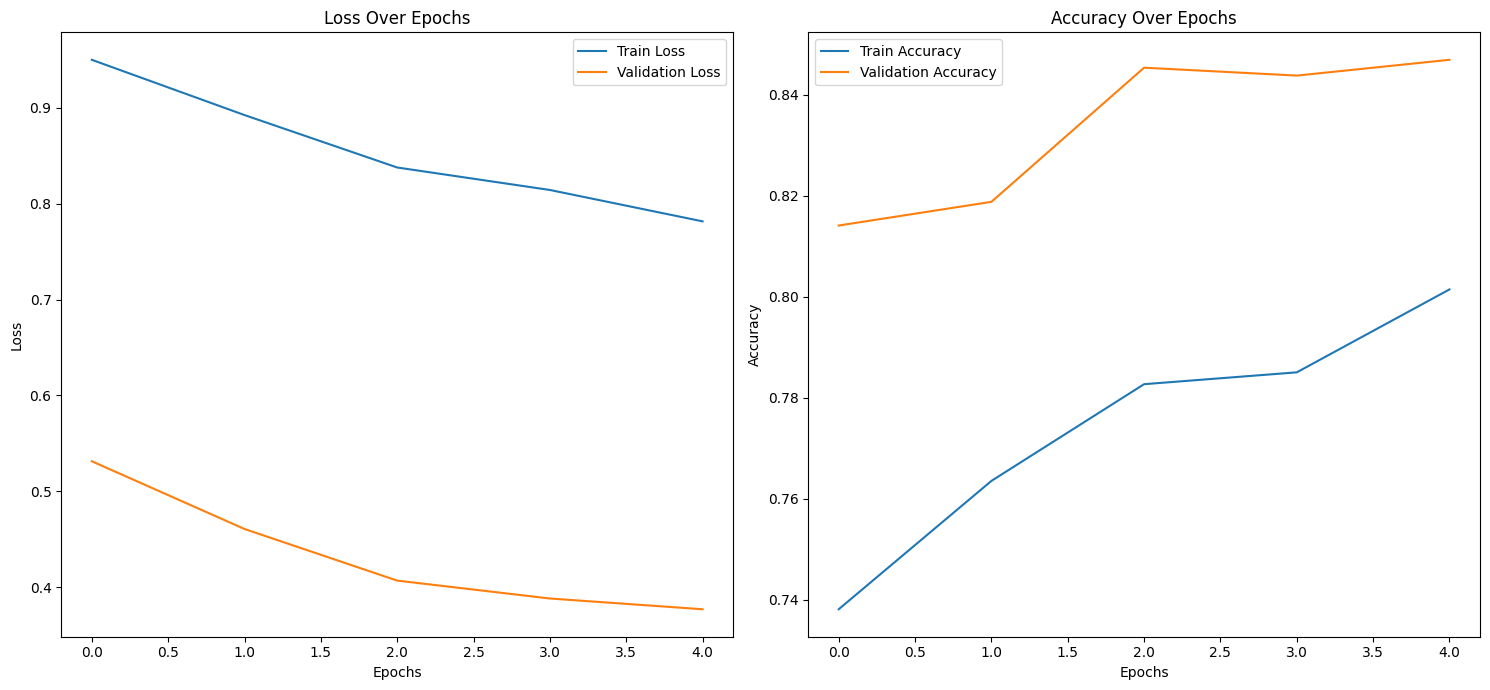

In [ ]:
plot_loss_curves(results)

> There is underfit so we will try to train model on more data and longer

In [ ]:
checkpoint_path = "/content/drive/MyDrive/AI_Project_Data/best_hybrid_model.pth"

# Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

# 1. Load the saved weights
hybrid_model_0 = HybridModel(feature_dim=feature_dim, fusion_hidden_dim=fusion_hidden_dim, lambda_grl=1.0).to(device)

hybrid_model.load_state_dict(checkpoint)

<All keys matched successfully>

### 5.5 Using the saved state dict to train on more dataset examples

In [ ]:
len(eval_dataloader), len(train_dataloader)

(500, 1999)

In [ ]:
from timeit import default_timer as timer

# Continue training using saved dict
NUM_EPOCHS = 1
START_EPOCH = 15  # epochs trained
LEARNING_RATE = 0.001
LAMBDA_ADV = 0.5


# 4. Define loss functions
criterion_cls = nn.BCEWithLogitsLoss()      # Binary classification loss
criterion_adv = nn.BCEWithLogitsLoss()      # Domain/adversarial loss

# 5. Optimizer
optimizer = torch.optim.SGD(hybrid_model_0.parameters(), lr=LEARNING_RATE, momentum=0.9)

# 7. Start training timer
start_time = timer()

results_0 = train_model(model=hybrid_model_0,
                      train_dataloader=train_dataloader, # more data examples
                      val_dataloader=eval_dataloader, # more data examples
                      optimizer=optimizer,
                      criterion_cls=criterion_cls,
                      criterion_adv=criterion_adv,
                      epochs=NUM_EPOCHS,
                      device=device,
                      lambda_adv=LAMBDA_ADV,
                      start_epoch=START_EPOCH)

end_time = timer()
print(f"Total training time: {end_time - start_time:.2f} seconds.")

Training Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/1999 [00:00<?, ?batch/s]

[Epoch 15] Sample Spatial Input Shape: torch.Size([32, 3, 224, 224])
[Epoch 15] class_output sample: tensor([0.1602])
[Epoch 15] adv_output sample: tensor([-0.0393])
[Batch 0] Loss: 1.0393 Acc: 0.4062
[Batch 5] Loss: 1.0383 Acc: 0.4427
[Batch 10] Loss: 1.0522 Acc: 0.4545
[Batch 15] Loss: 1.0358 Acc: 0.4863
[Batch 20] Loss: 1.0365 Acc: 0.4866
[Batch 25] Loss: 1.0462 Acc: 0.5000
[Batch 30] Loss: 1.0315 Acc: 0.5111
[Batch 35] Loss: 1.0232 Acc: 0.5174
[Batch 40] Loss: 1.0342 Acc: 0.5244
[Batch 45] Loss: 1.0337 Acc: 0.5306
[Batch 50] Loss: 1.0319 Acc: 0.5355
[Batch 55] Loss: 1.0259 Acc: 0.5413
[Batch 60] Loss: 1.0204 Acc: 0.5466
[Batch 65] Loss: 1.0431 Acc: 0.5516
[Batch 70] Loss: 1.0034 Acc: 0.5616
[Batch 75] Loss: 1.0041 Acc: 0.5695
[Batch 80] Loss: 0.9821 Acc: 0.5791


In [ ]:
checkpoint_path = "/content/drive/MyDrive/AI_Project_Data/hybrid_checkpoint.pth"

torch.save({
    'epoch': START_EPOCH + NUM_EPOCHS,
    'model_state_dict': hybrid_model_0.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'results': results_0  # training history
}, checkpoint_path)

## 6. Hybrid model summary

In [ ]:
#install torchinfo, import if it is available OMG this isssssss smooth
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo
  from torchinfo import summary

In [ ]:
summary(hybrid_model,
        input_data=(torch.randn(4, 3, 224, 224),  # spatial_input
                    torch.randn(4, 1, 224, 224)),  # frequency_input
        col_names=["input_size", "output_size", "num_params", "trainable"],
        depth=3)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
HybridModel                              [4, 3, 224, 224]          [4, 1]                    --                        True
├─SpatialBranch: 1-1                     [4, 3, 224, 224]          [4, 256]                  --                        True
│    └─Conv2d: 2-1                       [4, 3, 224, 224]          [4, 64, 224, 224]         1,792                     True
│    └─BatchNorm2d: 2-2                  [4, 64, 224, 224]         [4, 64, 224, 224]         128                       True
│    └─MaxPool2d: 2-3                    [4, 64, 224, 224]         [4, 64, 112, 112]         --                        --
│    └─Conv2d: 2-4                       [4, 64, 112, 112]         [4, 128, 112, 112]        73,856                    True
│    └─BatchNorm2d: 2-5                  [4, 128, 112, 112]        [4, 128, 112, 112]        256                       True
│    

## 7. Plot the loss and accutacy curves

In [ ]:
results

In [ ]:
results.keys()

dict_keys(['train_loss', 'train_acc', 'val_loss', 'val_acc'])

In [ ]:
plot_loss_curves(results)

## 8. Confusion Matrix

In [ ]:
try:
  import torchmetrics
except:
  !pip install torchmetrics
  import torchmetrics

In [ ]:
import torch
from torchmetrics import ConfusionMatrix
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

In [ ]:
y_pred_tensor = torch.tensor([0.0, 1.0, 0.0, 1.0, 0.0])  # Raw logits predictions
y_true_tensor = torch.tensor([0, 1, 0, 1, 0])  # Actual labels

# Apply sigmoid to predictions if they are raw logits
y_pred_prob = torch.sigmoid(y_pred_tensor)

# Convert to binary predictions
y_pred_binary = (y_pred_prob > 0.5).float()

# Initialize confusion matrix (for binary classification)
conf_mat = ConfusionMatrix(task="binary", num_classes=2)

# Compute confusion matrix
conf_mat_tensor = conf_mat(preds=y_pred_binary, target=y_true_tensor)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 7))
plot_confusion_matrix(conf_mat=conf_mat_tensor.numpy(),
                      class_names=class_names,
                      figsize=(10, 7),
                      ax=ax)

# Show the plot
plt.show()

## 9. Making a prediction on a custom image

In [ ]:
import torchvision
import torch
import matplotlib.pyplot as plt
from typing import List

def custom_image_prediction(model: torch.nn.Module,
                             image_path: str,
                             class_names: List[str] = None,
                             transform_spatial=None,
                             transform_frequency=None,
                             device=torch.device('cpu')):
    """
    Makes a prediction on a target image with a trained hybrid model (spatial + frequency)
    and plots the image and prediction.
    """

    # 1. Read image
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32) / 255.

    # 2. Apply transformations
    spatial_image = transform_spatial(target_image) if transform_spatial else target_image
    frequency_image = transform_frequency(target_image) if transform_frequency else target_image

    # 3. Move model to device
    model = model.to(device)

    # 4. Inference
    model.eval()
    with torch.inference_mode():
        # Add batch dimension
        spatial_image = spatial_image.unsqueeze(0).to(device)
        frequency_image = frequency_image.unsqueeze(0).to(device)

        class_output, _ = model(spatial_image, frequency_image)  # Only use classification output

        # Since it's binary classification (Real/Fake)
        pred_prob = torch.sigmoid(class_output).squeeze()
        pred_label = torch.round(pred_prob).int().item()

    # 5. Plot image
    plt.imshow(spatial_image.squeeze(0).permute(1, 2, 0).cpu())
    if class_names:
        title = f"Predicted: {class_names[pred_label]} | Prob: {pred_prob.cpu():.3f}"
    else:
        title = f"Predicted Class: {pred_label} | Prob: {pred_prob.cpu():.3f}"
    plt.title(title)
    plt.axis(False)
    plt.show()